In [1]:
import pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
debug=False
submission=False
batch_size=64
device='cuda'
out=r'C:\Users\Kaggle\BengaliAI\v14_output\epochs_0_to_150'
image_size=64*2
arch='pretrained'
model_name='se_resnext50_32x4d'

In [4]:
datadir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliai-cv19')
featherdir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliaicv19feather')
outdir = Path(r'C:\Users\Kaggle\BengaliAI\v14_output\epochs_0_to_150')

In [5]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [6]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
Wall time: 13.7 s


<a id="dataset"></a>
# Dataset

In [7]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


In [8]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [9]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


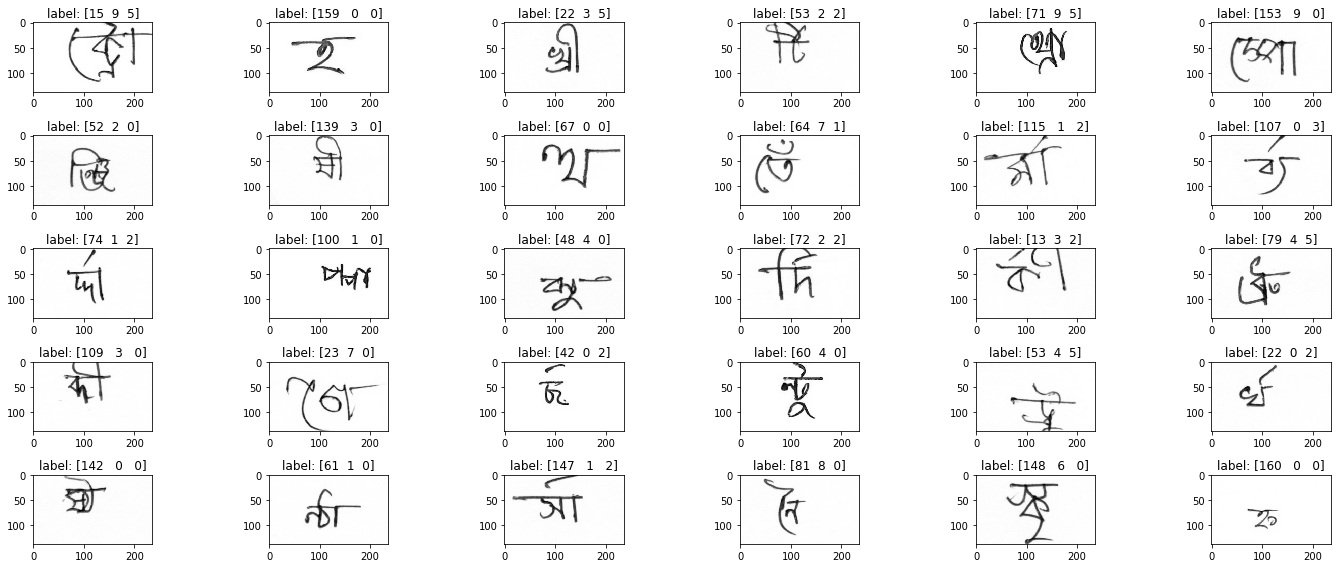

<Figure size 432x288 with 0 Axes>

In [10]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [11]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    
    #print("img.shape:", img.shape)
    
    # horizontal flip
    #if np.random.rand()<0.5:
    #img = img[:,::-1]
    
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 4
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    #tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
    #                        translation=(tx, ty))
    tform = AffineTransform(scale=(sx, sy), shear=shear_angle, rotation=rot_angle)
    
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    
    image[image < 20./255.] = 0
    
    is_black = image > threshold
    is_black[:5,:] = 0
    is_black[-5:,:] = 0
    is_black[:,:5] = 0
    is_black[:,-5:] = 0
    #is_black = connected_comp(is_black)
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left-5:height - right+5, top-5:width - bottom+5]
    
    lx, ly = height - right - left + 10, width - bottom - top + 10
    l = max(lx,ly)
    #make sure that the aspect ratio is kept in rescaling
    cropped_image = np.pad(cropped_image, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    # scaling
    cropped_image = cropped_image*(1/cropped_image.max())
    
    #pad
    cropped_image = np.pad(cropped_image, 8, pad_with)
    
    return cropped_image

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

In [12]:
# Erosion
def erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Dilation
def dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img


def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 3, 2)))
    return kernel

# Opening
def opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

#Closing
def closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img

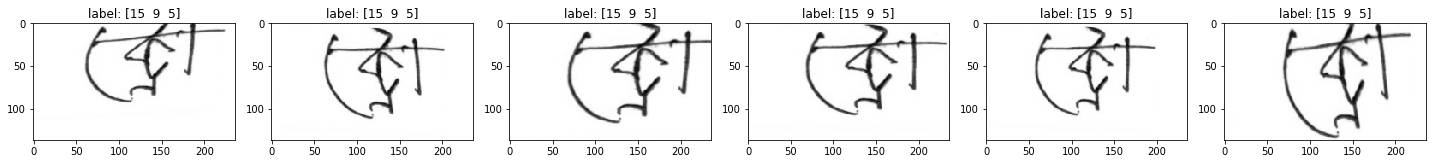

In [13]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

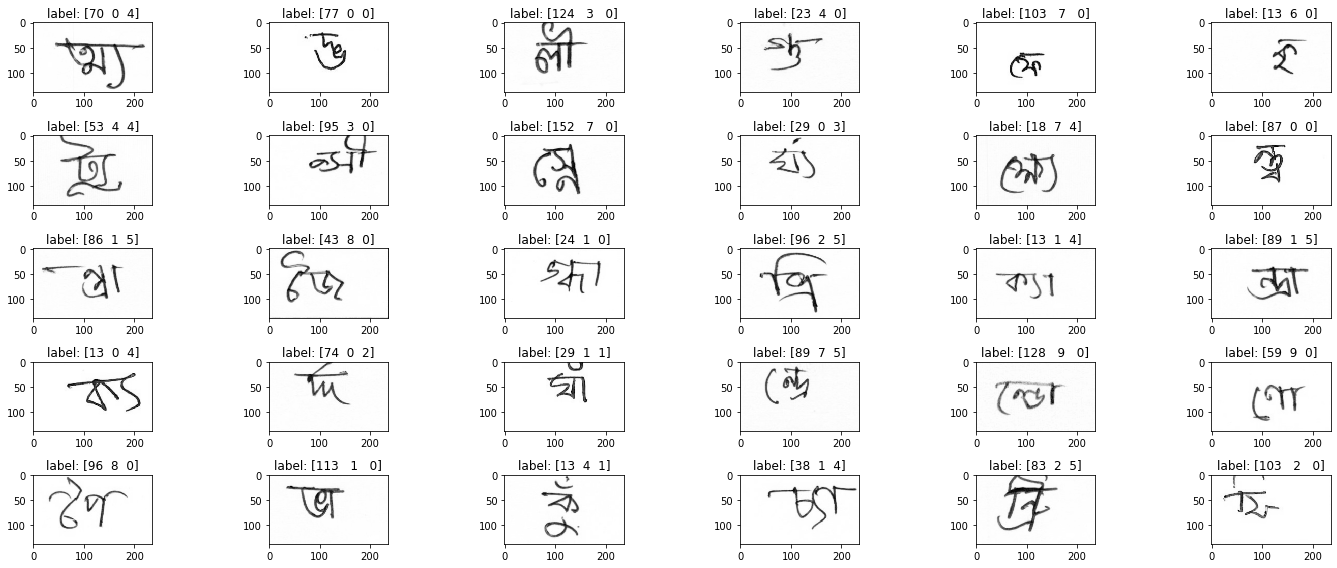

In [14]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

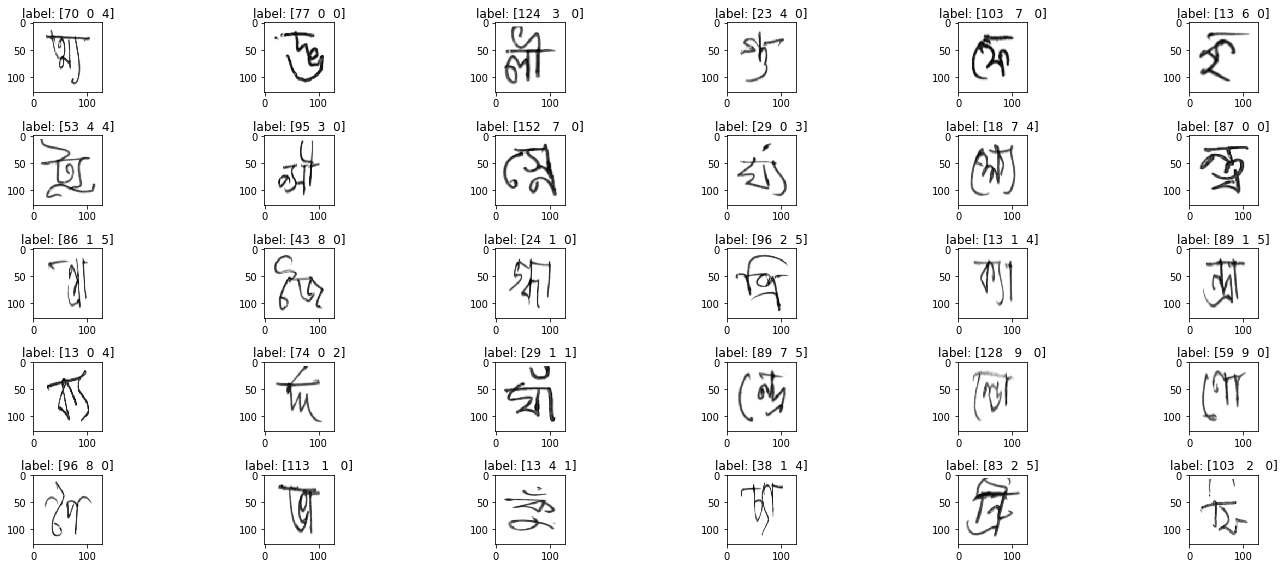

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(resize(crop_char_image(image, threshold=40./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [16]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']
        
        
class Transform:
    def __init__(self, affine=True, crop=False, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
                    
        # remove noise
        # x [x<28./255.] = 0
        
        # horizontal flip
        #x = x[:,:,::-1,:]

        
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
        
        

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.01,#0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        #if self.normalize:
        #    x = (x.astype(np.float32) - 0.0692) / 0.2051
        # normalize by its max val
        # x = x * (255./x.max())
        
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [17]:
train_transform = Transform( crop=False,
    size=(236, 137), threshold=40.,
    sigma=-1., blur_ratio=0, noise_ratio=0, cutout_ratio=0,
    grid_distortion_ratio=0, random_brightness_ratio=0,
    piece_affine_ratio=0.1, ssr_ratio=0.1)

In [18]:
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

In [19]:
class Cutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.p = p
        self.mask_size = mask_size
        self.cutout_inside = cutout_inside
        self.mask_color = mask_color

        self.mask_size_half = mask_size // 2
        self.offset = 1 if mask_size % 2 == 0 else 0

    def __call__(self, image):
        image_all = copy.copy(image)
        image = image[0,0]
        #image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]

        if self.cutout_inside:
            cxmin, cxmax = self.mask_size_half, w + self.offset - self.mask_size_half
            cymin, cymax = self.mask_size_half, h + self.offset - self.mask_size_half
        else:
            cxmin, cxmax = 0, w + self.offset
            cymin, cymax = 0, h + self.offset

        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - self.mask_size_half
        ymin = cy - self.mask_size_half
        xmax = xmin + self.mask_size
        ymax = ymin + self.mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        
        
        image_all[:, :, ymin:ymax, xmin:xmax] = self.mask_color
        return image_all

In [20]:
cutout = Cutout(80, 1, True, 0)

### Let's final check the processed images, which will be trained by the model.

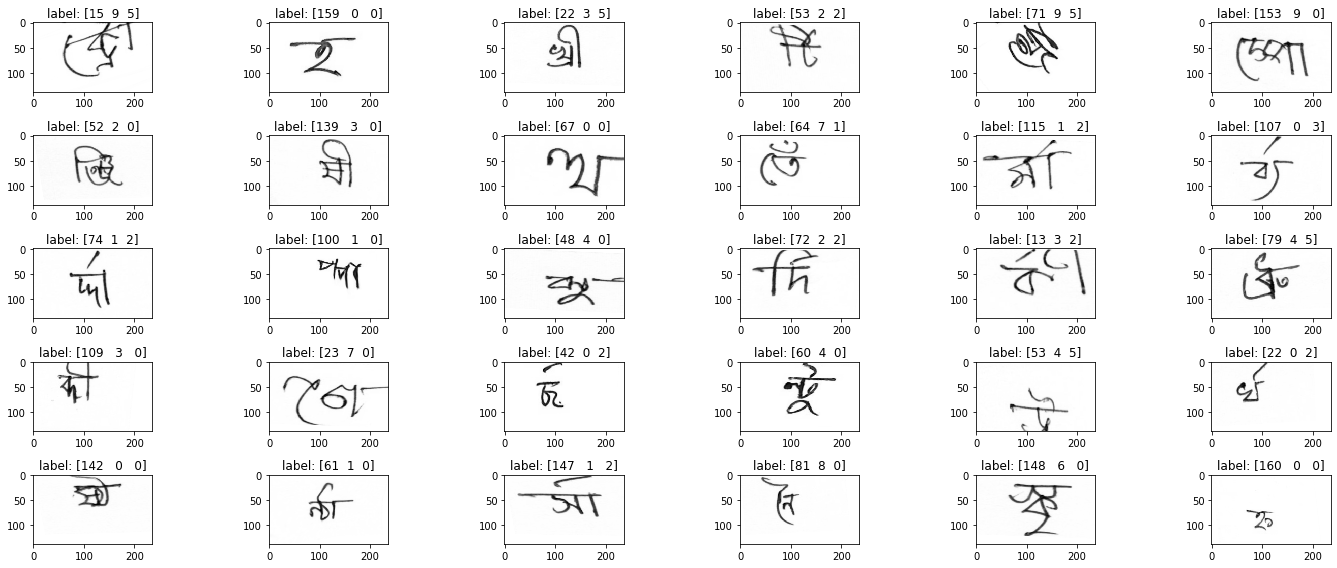

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [22]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [23]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [24]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [25]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [26]:
# GEM
# import torch.nn.functional as F

def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):

    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [27]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin1_2 = LinearBlock(hdim, 168, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers1 = Sequential(lin1_1, lin1_2)
        
        lin2_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2_2 = LinearBlock(hdim, 11, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers2 = Sequential(lin2_1, lin2_2)

        lin3_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin3_2 = LinearBlock(hdim, 7, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers3 = Sequential(lin3_1, lin3_2)

        self.pool = GeM()

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:

            h1 = self.pool(h)[:,:,0,0]
            h2 = self.pool(h)[:,:,0,0]
            h3 = self.pool(h)[:,:,0,0]

            
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h1 = h.view(bs, ch*height*width)
            h2 = h.view(bs, ch*height*width)
            h3 = h.view(bs, ch*height*width)
        for layer in self.lin_layers1:
            h1 = layer(h1)
        for layer in self.lin_layers2:
            h2 = layer(h2)
        for layer in self.lin_layers3:
            h3 = layer(h3)
            
            
        return h1, h2, h3

## Classifier

In [28]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.999:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
        else:
            # cutout
            x = cutout(x)
        
        
        pred = self.predictor(x)
        
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_grapheme #self.n_total_class
            preds = pred #torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
            
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):
        
        
        pred = self.predictor(x)
        #pred1 = self.predictor(x[:,:,::-1,:])
        #pred2 = self.predictor(x)
        #pred = (pred1+pred2)/2 
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

## prepare data

In [30]:
import copy
import numpy as np
import pandas as pd
import iterstrat
#!pip install iterative-stratification

#get data
nfold = 10
seed = 22

train_df = copy.copy(train)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train_df.values[:,1:]

train_df['fold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

#------------------------------

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices = np.array(list(train_df[train_df['fold']!=1].index)))
    #    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(236, 137)),
    indices = np.array(list(train_df[train_df['fold']==1].index)))
#    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train_dataset 180756 valid_dataset 20084
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [31]:
pretrainedmodels

<module 'pretrainedmodels' from 'C:\\Users\\Rajneesh Tiwari\\.conda\\envs\\Pytorch\\lib\\site-packages\\pretrainedmodels\\__init__.py'>

In [32]:
# #load weights
# predictor.train()

classifier = BengaliClassifier(predictor).to(device)

In [33]:
predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

## Ignite utility

pytorch-ignite utility class for training

In [34]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        

        loss, metrics, pred_y = classifier(x, y)
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'C:\Users\Kaggle\BengaliAI\v14_output\epochs_0_to_150\models\model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [35]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.003)
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.000343)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [36]:
trainer.run(train_loader, max_epochs=150)

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 1, 'iteration': 2825, 'train/loss': 7.577304035034855, 'train/loss_grapheme': 2.8664410812453887, 'train/loss_vowel': 1.0983436665070796, 'train/loss_consonant': 0.7460782143921979, 'train/acc_grapheme': 0.3208904867256637, 'train/acc_vowel': 0.5854037610619469, 'train/acc_consonant': 0.7295818584070796, 'train/recall': 0.4743733296091286, 'valid/loss': 1.7371520612649858, 'valid/loss_grapheme': 0.5935348057822817, 'valid/loss_vowel': 0.31518014439731645, 'valid/loss_consonant': 0.23490230648950405, 'valid/acc_grapheme': 0.8744373162665361, 'valid/acc_vowel': 0.9448416829985301, 'valid/acc_consonant': 0.9443708659970602, 'valid/recall': 0.9108330146782856, 'lr': 0.003, 'elapsed_time': 3775.1477882}
epoch      1 train/loss  7.577304 train/loss_grapheme  2.866441 train/loss_vowel  1.098344 train/loss_consonant  0.746078 train/acc_grapheme  0.320890 train/acc_vowel  0.585404 train/acc_consonant  0.729582 train/recall  0.474373 valid/loss  1.737152 valid/loss_grapheme  0.593535 v

{'epoch': 2, 'iteration': 5650, 'train/loss': 5.56471404442745, 'train/loss_grapheme': 2.0811002108375583, 'train/loss_vowel': 0.8613978151594643, 'train/loss_consonant': 0.5411158054328598, 'train/acc_grapheme': 0.44983849557522126, 'train/acc_vowel': 0.6438904867256637, 'train/acc_consonant': 0.7702588495575221, 'train/recall': 0.558341955476326, 'valid/loss': 1.1821140834859982, 'valid/loss_grapheme': 0.4318831677839255, 'valid/loss_vowel': 0.18400948928894512, 'valid/loss_consonant': 0.1343382571817963, 'valid/acc_grapheme': 0.9013542687408133, 'valid/acc_vowel': 0.9710772905438511, 'valid/acc_consonant': 0.9717241854483096, 'valid/recall': 0.9275032675445452, 'lr': 0.003, 'elapsed_time': 7545.9344196}
epoch      2 train/loss  5.564714 train/loss_grapheme  2.081100 train/loss_vowel  0.861398 train/loss_consonant  0.541116 train/acc_grapheme  0.449838 train/acc_vowel  0.643890 train/acc_consonant  0.770259 train/recall  0.558342 valid/loss  1.182114 valid/loss_grapheme  0.431883 val

{'epoch': 3, 'iteration': 8475, 'train/loss': 5.037578405363369, 'train/loss_grapheme': 1.8794311582567418, 'train/loss_vowel': 0.784378058543775, 'train/loss_consonant': 0.4943380319729315, 'train/acc_grapheme': 0.4718993362831858, 'train/acc_vowel': 0.6521227876106195, 'train/acc_consonant': 0.7729026548672566, 'train/recall': 0.5773410417506225, 'valid/loss': 0.947884800517635, 'valid/loss_grapheme': 0.34079542945904334, 'valid/loss_vowel': 0.1353920319467593, 'valid/loss_consonant': 0.13090190841893481, 'valid/acc_grapheme': 0.9149160950514454, 'valid/acc_vowel': 0.977109872611465, 'valid/acc_consonant': 0.9732552976482116, 'valid/recall': 0.9427263324599908, 'lr': 0.003, 'elapsed_time': 11320.0640409}
epoch      3 train/loss  5.037578 train/loss_grapheme  1.879431 train/loss_vowel  0.784378 train/loss_consonant  0.494338 train/acc_grapheme  0.471899 train/acc_vowel  0.652123 train/acc_consonant  0.772903 train/recall  0.577341 valid/loss  0.947885 valid/loss_grapheme  0.340795 val

{'epoch': 4, 'iteration': 11300, 'train/loss': 4.848893605713296, 'train/loss_grapheme': 1.803528950024495, 'train/loss_vowel': 0.7604738168959069, 'train/loss_consonant': 0.48136188283167053, 'train/acc_grapheme': 0.48545796460176993, 'train/acc_vowel': 0.6572621681415929, 'train/acc_consonant': 0.7769115044247787, 'train/recall': 0.5885719066531252, 'valid/loss': 0.8646928108042213, 'valid/loss_grapheme': 0.28743440577179, 'valid/loss_vowel': 0.16640723271259836, 'valid/loss_consonant': 0.12341676533791669, 'valid/acc_grapheme': 0.9355401763841253, 'valid/acc_vowel': 0.9798467356687898, 'valid/acc_consonant': 0.9770103503184714, 'valid/recall': 0.9560589179906599, 'lr': 0.003, 'elapsed_time': 15091.825407799999}
epoch      4 train/loss  4.848894 train/loss_grapheme  1.803529 train/loss_vowel  0.760474 train/loss_consonant  0.481362 train/acc_grapheme  0.485458 train/acc_vowel  0.657262 train/acc_consonant  0.776912 train/recall  0.588572 valid/loss  0.864693 valid/loss_grapheme  0.28

{'epoch': 5, 'iteration': 14125, 'train/loss': 4.609542754962381, 'train/loss_grapheme': 1.7102696537127537, 'train/loss_vowel': 0.7250385510684114, 'train/loss_consonant': 0.46396489728868534, 'train/acc_grapheme': 0.5005221238938052, 'train/acc_vowel': 0.665745575221239, 'train/acc_consonant': 0.7807942477876106, 'train/recall': 0.6004071708075507, 'valid/loss': 0.8699307091486682, 'valid/loss_grapheme': 0.291754812666565, 'valid/loss_vowel': 0.16217092500560604, 'valid/loss_consonant': 0.12425015907093978, 'valid/acc_grapheme': 0.9371708108770211, 'valid/acc_vowel': 0.9834295382165605, 'valid/acc_consonant': 0.9803941082802548, 'valid/recall': 0.9560670178993235, 'lr': 0.003, 'elapsed_time': 18860.2914581}
epoch      5 train/loss  4.609543 train/loss_grapheme  1.710270 train/loss_vowel  0.725039 train/loss_consonant  0.463965 train/acc_grapheme  0.500522 train/acc_vowel  0.665746 train/acc_consonant  0.780794 train/recall  0.600407 valid/loss  0.869931 valid/loss_grapheme  0.291755 

{'epoch': 6, 'iteration': 16950, 'train/loss': 4.521257621134277, 'train/loss_grapheme': 1.674690503921129, 'train/loss_vowel': 0.7187508290979715, 'train/loss_consonant': 0.45312578587009844, 'train/acc_grapheme': 0.511228982300885, 'train/acc_vowel': 0.6701482300884956, 'train/acc_consonant': 0.7881880530973451, 'train/recall': 0.6116224718391887, 'valid/loss': 0.8480134335862604, 'valid/loss_grapheme': 0.2665817516672004, 'valid/loss_vowel': 0.1786285642842958, 'valid/loss_consonant': 0.13622136558791634, 'valid/acc_grapheme': 0.9457412114159724, 'valid/acc_vowel': 0.9824228319451249, 'valid/acc_consonant': 0.9816381369426752, 'valid/recall': 0.9649201349683865, 'lr': 0.003, 'elapsed_time': 22629.6353731}
epoch      6 train/loss  4.521258 train/loss_grapheme  1.674691 train/loss_vowel  0.718751 train/loss_consonant  0.453126 train/acc_grapheme  0.511229 train/acc_vowel  0.670148 train/acc_consonant  0.788188 train/recall  0.611622 valid/loss  0.848013 valid/loss_grapheme  0.266582 v

{'epoch': 7, 'iteration': 19775, 'train/loss': 4.367110462441908, 'train/loss_grapheme': 1.6149385452138638, 'train/loss_vowel': 0.6947546269210566, 'train/loss_consonant': 0.4424787482197306, 'train/acc_grapheme': 0.5303384955752212, 'train/acc_vowel': 0.6841426991150442, 'train/acc_consonant': 0.7946238938053097, 'train/recall': 0.6260960514655879, 'valid/loss': 0.7991437924325846, 'valid/loss_grapheme': 0.2644155593292349, 'valid/loss_vowel': 0.16051058319343883, 'valid/loss_consonant': 0.10980209269246478, 'valid/acc_grapheme': 0.946499111954924, 'valid/acc_vowel': 0.9851711783439491, 'valid/acc_consonant': 0.9801950636942676, 'valid/recall': 0.9676639794161914, 'lr': 0.003, 'elapsed_time': 26396.6703075}
epoch      7 train/loss  4.367110 train/loss_grapheme  1.614939 train/loss_vowel  0.694755 train/loss_consonant  0.442479 train/acc_grapheme  0.530338 train/acc_vowel  0.684143 train/acc_consonant  0.794624 train/recall  0.626096 valid/loss  0.799144 valid/loss_grapheme  0.264416 

{'epoch': 8, 'iteration': 22600, 'train/loss': 4.326955079431028, 'train/loss_grapheme': 1.5995559017083285, 'train/loss_vowel': 0.6874858145639959, 'train/loss_consonant': 0.4403574590503642, 'train/acc_grapheme': 0.5234137168141593, 'train/acc_vowel': 0.678987831858407, 'train/acc_consonant': 0.7904148230088496, 'train/recall': 0.6185558247299914, 'valid/loss': 0.6781037763045852, 'valid/loss_grapheme': 0.23332143442076483, 'valid/loss_vowel': 0.11588986206111634, 'valid/loss_consonant': 0.09557104399012532, 'valid/acc_grapheme': 0.9453928833904948, 'valid/acc_vowel': 0.9821357484076433, 'valid/acc_consonant': 0.9840151886330231, 'valid/recall': 0.9643463732208073, 'lr': 0.003, 'elapsed_time': 30168.9880104}
epoch      8 train/loss  4.326955 train/loss_grapheme  1.599556 train/loss_vowel  0.687486 train/loss_consonant  0.440357 train/acc_grapheme  0.523414 train/acc_vowel  0.678988 train/acc_consonant  0.790415 train/recall  0.618556 valid/loss  0.678104 valid/loss_grapheme  0.233321

{'epoch': 9, 'iteration': 25425, 'train/loss': 4.300635106289281, 'train/loss_grapheme': 1.5859268909297157, 'train/loss_vowel': 0.6877989802437019, 'train/loss_consonant': 0.4409823429465821, 'train/acc_grapheme': 0.5239269911504425, 'train/acc_vowel': 0.675849557522124, 'train/acc_consonant': 0.7879911504424778, 'train/recall': 0.6183310241901874, 'valid/loss': 0.6240356241346924, 'valid/loss_grapheme': 0.21103895154253693, 'valid/loss_vowel': 0.11496947067463474, 'valid/loss_consonant': 0.08698825073090329, 'valid/acc_grapheme': 0.9461622672709455, 'valid/acc_vowel': 0.9835788216560509, 'valid/acc_consonant': 0.9827826433121019, 'valid/recall': 0.9639453596990031, 'lr': 0.003, 'elapsed_time': 33937.2580002}
epoch      9 train/loss  4.300635 train/loss_grapheme  1.585927 train/loss_vowel  0.687799 train/loss_consonant  0.440982 train/acc_grapheme  0.523927 train/acc_vowel  0.675850 train/acc_consonant  0.787991 train/recall  0.618331 valid/loss  0.624036 valid/loss_grapheme  0.211039

{'epoch': 10, 'iteration': 28250, 'train/loss': 4.118289736456576, 'train/loss_grapheme': 1.513766161849541, 'train/loss_vowel': 0.6651609656860871, 'train/loss_consonant': 0.4255964437680962, 'train/acc_grapheme': 0.5458595132743362, 'train/acc_vowel': 0.6889203539823009, 'train/acc_consonant': 0.7970785398230088, 'train/recall': 0.6355025996098079, 'valid/loss': 0.5678668913378078, 'valid/loss_grapheme': 0.19619919644419553, 'valid/loss_vowel': 0.0984419286369708, 'valid/loss_consonant': 0.07702657122425972, 'valid/acc_grapheme': 0.9503804813816756, 'valid/acc_vowel': 0.9850104115629593, 'valid/acc_consonant': 0.9836668606075453, 'valid/recall': 0.9639195233374628, 'lr': 0.003, 'elapsed_time': 37710.295494800004}
epoch     10 train/loss  4.118290 train/loss_grapheme  1.513766 train/loss_vowel  0.665161 train/loss_consonant  0.425596 train/acc_grapheme  0.545860 train/acc_vowel  0.688920 train/acc_consonant  0.797079 train/recall  0.635503 valid/loss  0.567867 valid/loss_grapheme  0.1

{'epoch': 11, 'iteration': 31075, 'train/loss': 4.052532716272151, 'train/loss_grapheme': 1.492574084585747, 'train/loss_vowel': 0.6493170651694579, 'train/loss_consonant': 0.4180674827942806, 'train/acc_grapheme': 0.5412953539823009, 'train/acc_vowel': 0.6883097345132743, 'train/acc_consonant': 0.7948694690265486, 'train/recall': 0.6331689011162017, 'valid/loss': 0.6001311071739075, 'valid/loss_grapheme': 0.19564926171093988, 'valid/loss_vowel': 0.11898863237279995, 'valid/loss_consonant': 0.08984395105890028, 'valid/acc_grapheme': 0.9553183182263596, 'valid/acc_vowel': 0.9866142515923567, 'valid/acc_consonant': 0.9857683121019108, 'valid/recall': 0.9715261791966311, 'lr': 0.003, 'elapsed_time': 41481.2383807}
epoch     11 train/loss  4.052533 train/loss_grapheme  1.492574 train/loss_vowel  0.649317 train/loss_consonant  0.418067 train/acc_grapheme  0.541295 train/acc_vowel  0.688310 train/acc_consonant  0.794869 train/recall  0.633169 valid/loss  0.600131 valid/loss_grapheme  0.19564

{'epoch': 12, 'iteration': 33900, 'train/loss': 4.025990245194562, 'train/loss_grapheme': 1.4804009126799296, 'train/loss_vowel': 0.6475743872395395, 'train/loss_consonant': 0.41761402938218245, 'train/acc_grapheme': 0.5518307522123894, 'train/acc_vowel': 0.6943340707964603, 'train/acc_consonant': 0.8003772123893806, 'train/recall': 0.6407516985596695, 'valid/loss': 0.6655020151927973, 'valid/loss_grapheme': 0.22397047791416477, 'valid/loss_vowel': 0.12221391999702545, 'valid/loss_consonant': 0.09534713852509952, 'valid/acc_grapheme': 0.94874984688878, 'valid/acc_vowel': 0.985718550955414, 'valid/acc_consonant': 0.9848228503184714, 'valid/recall': 0.9679736957215446, 'lr': 0.003, 'elapsed_time': 45244.7977129}
epoch     12 train/loss  4.025990 train/loss_grapheme  1.480401 train/loss_vowel  0.647574 train/loss_consonant  0.417614 train/acc_grapheme  0.551831 train/acc_vowel  0.694334 train/acc_consonant  0.800377 train/recall  0.640752 valid/loss  0.665502 valid/loss_grapheme  0.223970

{'epoch': 13, 'iteration': 36725, 'train/loss': 4.076013257851643, 'train/loss_grapheme': 1.499585714432518, 'train/loss_vowel': 0.6556463749258392, 'train/loss_consonant': 0.4211954505451485, 'train/acc_grapheme': 0.5456106194690266, 'train/acc_vowel': 0.6922311946902655, 'train/acc_consonant': 0.7980663716814159, 'train/recall': 0.6391760451250135, 'valid/loss': 0.5204342514940887, 'valid/loss_grapheme': 0.17202222594030345, 'valid/loss_vowel': 0.09432956621430483, 'valid/loss_consonant': 0.08206023246192248, 'valid/acc_grapheme': 0.9559920075943165, 'valid/acc_vowel': 0.988344408378246, 'valid/acc_consonant': 0.9856573064674179, 'valid/recall': 0.9707327697233492, 'lr': 0.003, 'elapsed_time': 49011.462769900005}
epoch     13 train/loss  4.076013 train/loss_grapheme  1.499586 train/loss_vowel  0.655646 train/loss_consonant  0.421195 train/acc_grapheme  0.545611 train/acc_vowel  0.692231 train/acc_consonant  0.798066 train/recall  0.639176 valid/loss  0.520434 valid/loss_grapheme  0.1

{'epoch': 14, 'iteration': 39550, 'train/loss': 4.06806320225243, 'train/loss_grapheme': 1.4930443638035682, 'train/loss_vowel': 0.658485575002511, 'train/loss_consonant': 0.4234888995010241, 'train/acc_grapheme': 0.536537610619469, 'train/acc_vowel': 0.6805829646017699, 'train/acc_consonant': 0.7909767699115045, 'train/recall': 0.6273202349956678, 'valid/loss': 0.4802070704709952, 'valid/loss_grapheme': 0.15816757355810732, 'valid/loss_vowel': 0.08986191098002871, 'valid/loss_consonant': 0.07401001072565841, 'valid/acc_grapheme': 0.9608303221460068, 'valid/acc_vowel': 0.9878085191082803, 'valid/acc_consonant': 0.9867137738853503, 'valid/recall': 0.973189542900674, 'lr': 0.003, 'elapsed_time': 52778.681730000004}
epoch     14 train/loss  4.068063 train/loss_grapheme  1.493044 train/loss_vowel  0.658486 train/loss_consonant  0.423489 train/acc_grapheme  0.536538 train/acc_vowel  0.680583 train/acc_consonant  0.790977 train/recall  0.627320 valid/loss  0.480207 valid/loss_grapheme  0.158

{'epoch': 15, 'iteration': 42375, 'train/loss': 3.936229765763325, 'train/loss_grapheme': 1.441746315887544, 'train/loss_vowel': 0.6399622460111843, 'train/loss_consonant': 0.41277488601023116, 'train/acc_grapheme': 0.5414867256637168, 'train/acc_vowel': 0.6810674778761062, 'train/acc_consonant': 0.7896084070796461, 'train/recall': 0.6272116507641026, 'valid/loss': 0.6367199747425736, 'valid/loss_grapheme': 0.19529864540810038, 'valid/loss_vowel': 0.1474034034285196, 'valid/loss_consonant': 0.09871928004702185, 'valid/acc_grapheme': 0.9588628429691327, 'valid/acc_vowel': 0.9868630573248408, 'valid/acc_consonant': 0.9869625796178344, 'valid/recall': 0.9752170656680367, 'lr': 0.003, 'elapsed_time': 56543.6009933}
epoch     15 train/loss  3.936230 train/loss_grapheme  1.441746 train/loss_vowel  0.639962 train/loss_consonant  0.412775 train/acc_grapheme  0.541487 train/acc_vowel  0.681067 train/acc_consonant  0.789608 train/recall  0.627212 valid/loss  0.636720 valid/loss_grapheme  0.19529

{'epoch': 16, 'iteration': 45200, 'train/loss': 3.862670131404843, 'train/loss_grapheme': 1.4159607714928883, 'train/loss_vowel': 0.6257484563664262, 'train/loss_consonant': 0.40500013315110606, 'train/acc_grapheme': 0.5486603982300885, 'train/acc_vowel': 0.688912610619469, 'train/acc_consonant': 0.7957942477876107, 'train/recall': 0.6379793163271801, 'valid/loss': 0.5791794202130311, 'valid/loss_grapheme': 0.19210180286673983, 'valid/loss_vowel': 0.11050133720325057, 'valid/loss_consonant': 0.08447447654073405, 'valid/acc_grapheme': 0.9557393740813327, 'valid/acc_vowel': 0.9869625796178344, 'valid/acc_consonant': 0.9870123407643312, 'valid/recall': 0.9720635304495246, 'lr': 0.003, 'elapsed_time': 60309.1495314}
epoch     16 train/loss  3.862670 train/loss_grapheme  1.415961 train/loss_vowel  0.625748 train/loss_consonant  0.405000 train/acc_grapheme  0.548660 train/acc_vowel  0.688913 train/acc_consonant  0.795794 train/recall  0.637979 valid/loss  0.579179 valid/loss_grapheme  0.1921

{'epoch': 17, 'iteration': 48025, 'train/loss': 3.9082169463993175, 'train/loss_grapheme': 1.4326571766742036, 'train/loss_vowel': 0.6333299761140241, 'train/loss_consonant': 0.40957261676479756, 'train/acc_grapheme': 0.540983407079646, 'train/acc_vowel': 0.6838506637168141, 'train/acc_consonant': 0.7927931415929204, 'train/recall': 0.6280198008550432, 'valid/loss': 0.48265731937376555, 'valid/loss_grapheme': 0.16384074379019675, 'valid/loss_vowel': 0.08259021751819902, 'valid/loss_consonant': 0.07238561478532424, 'valid/acc_grapheme': 0.9616379838314552, 'valid/acc_vowel': 0.9874984688878001, 'valid/acc_consonant': 0.9861664012738853, 'valid/recall': 0.9742101491286375, 'lr': 0.003, 'elapsed_time': 64083.9015883}
epoch     17 train/loss  3.908217 train/loss_grapheme  1.432657 train/loss_vowel  0.633330 train/loss_consonant  0.409573 train/acc_grapheme  0.540983 train/acc_vowel  0.683851 train/acc_consonant  0.792793 train/recall  0.628020 valid/loss  0.482657 valid/loss_grapheme  0.16

{'epoch': 18, 'iteration': 50850, 'train/loss': 3.82340855602142, 'train/loss_grapheme': 1.402095207800116, 'train/loss_vowel': 0.6172054581766108, 'train/loss_consonant': 0.40201268400502416, 'train/acc_grapheme': 0.5610387168141593, 'train/acc_vowel': 0.701521017699115, 'train/acc_consonant': 0.8020951327433627, 'train/recall': 0.647742103355314, 'valid/loss': 0.5471696637238667, 'valid/loss_grapheme': 0.17245134568897783, 'valid/loss_vowel': 0.11298507008298188, 'valid/loss_consonant': 0.08928190099348308, 'valid/acc_grapheme': 0.961687744977952, 'valid/acc_vowel': 0.9879080414012739, 'valid/acc_consonant': 0.9861664012738853, 'valid/recall': 0.9750056459410521, 'lr': 0.003, 'elapsed_time': 67853.6998841}
epoch     18 train/loss  3.823409 train/loss_grapheme  1.402095 train/loss_vowel  0.617205 train/loss_consonant  0.402013 train/acc_grapheme  0.561039 train/acc_vowel  0.701521 train/acc_consonant  0.802095 train/recall  0.647742 valid/loss  0.547170 valid/loss_grapheme  0.172451 v

{'epoch': 19, 'iteration': 53675, 'train/loss': 3.855793761848348, 'train/loss_grapheme': 1.4097670826210384, 'train/loss_vowel': 0.6276203630047035, 'train/loss_consonant': 0.4086392293039676, 'train/acc_grapheme': 0.5515398230088495, 'train/acc_vowel': 0.6896869469026549, 'train/acc_consonant': 0.7945077433628318, 'train/recall': 0.6378903902744795, 'valid/loss': 0.5079037153701873, 'valid/loss_grapheme': 0.17100242041288669, 'valid/loss_vowel': 0.08414481262302702, 'valid/loss_consonant': 0.08175406384335202, 'valid/acc_grapheme': 0.9598083047525722, 'valid/acc_vowel': 0.9885549363057324, 'valid/acc_consonant': 0.9864152070063694, 'valid/recall': 0.9726591046238034, 'lr': 0.003, 'elapsed_time': 71619.95188970001}
epoch     19 train/loss  3.855794 train/loss_grapheme  1.409767 train/loss_vowel  0.627620 train/loss_consonant  0.408639 train/acc_grapheme  0.551540 train/acc_vowel  0.689687 train/acc_consonant  0.794508 train/recall  0.637890 valid/loss  0.507904 valid/loss_grapheme  0.

{'epoch': 20, 'iteration': 56500, 'train/loss': 3.797323434553315, 'train/loss_grapheme': 1.3884731191897814, 'train/loss_vowel': 0.6172478689530254, 'train/loss_consonant': 0.403129327603146, 'train/acc_grapheme': 0.5633152654867256, 'train/acc_vowel': 0.701012168141593, 'train/acc_consonant': 0.8013130530973451, 'train/recall': 0.6491007388742984, 'valid/loss': 0.5547554476815424, 'valid/loss_grapheme': 0.17736491017565606, 'valid/loss_vowel': 0.11455605544482067, 'valid/loss_consonant': 0.08546957304807985, 'valid/acc_grapheme': 0.9613891780989711, 'valid/acc_vowel': 0.9877587579617835, 'valid/acc_consonant': 0.9861664012738853, 'valid/recall': 0.9721087507756512, 'lr': 0.003, 'elapsed_time': 75389.6763087}
epoch     20 train/loss  3.797323 train/loss_grapheme  1.388473 train/loss_vowel  0.617248 train/loss_consonant  0.403129 train/acc_grapheme  0.563315 train/acc_vowel  0.701012 train/acc_consonant  0.801313 train/recall  0.649101 valid/loss  0.554755 valid/loss_grapheme  0.177365

{'epoch': 21, 'iteration': 59325, 'train/loss': 3.83886706297904, 'train/loss_grapheme': 1.4055624296021672, 'train/loss_vowel': 0.6228557585865523, 'train/loss_consonant': 0.4048864448677122, 'train/acc_grapheme': 0.5528097345132743, 'train/acc_vowel': 0.6941449115044247, 'train/acc_consonant': 0.7980254424778761, 'train/recall': 0.6391873825066625, 'valid/loss': 0.5779919776187581, 'valid/loss_grapheme': 0.1857821917410489, 'valid/loss_vowel': 0.11793829351189031, 'valid/loss_consonant': 0.08848929897567649, 'valid/acc_grapheme': 0.9610791278784908, 'valid/acc_vowel': 0.9888037420382165, 'valid/acc_consonant': 0.9868132961783439, 'valid/recall': 0.9747267619263951, 'lr': 0.003, 'elapsed_time': 79157.2904228}
epoch     21 train/loss  3.838867 train/loss_grapheme  1.405562 train/loss_vowel  0.622856 train/loss_consonant  0.404886 train/acc_grapheme  0.552810 train/acc_vowel  0.694145 train/acc_consonant  0.798025 train/recall  0.639187 valid/loss  0.577992 valid/loss_grapheme  0.185782

{'epoch': 22, 'iteration': 62150, 'train/loss': 3.740208493624113, 'train/loss_grapheme': 1.3673399113263704, 'train/loss_vowel': 0.6081953905338208, 'train/loss_consonant': 0.3973332801164515, 'train/acc_grapheme': 0.5629723451327433, 'train/acc_vowel': 0.6972754424778761, 'train/acc_consonant': 0.7987400442477877, 'train/recall': 0.6463900644565402, 'valid/loss': 0.5532948186822758, 'valid/loss_grapheme': 0.1823559369251227, 'valid/loss_vowel': 0.10328887827741871, 'valid/loss_consonant': 0.08529406555803717, 'valid/acc_grapheme': 0.9594714600685939, 'valid/acc_vowel': 0.9886544585987261, 'valid/acc_consonant': 0.9864152070063694, 'valid/recall': 0.974869857666257, 'lr': 0.003, 'elapsed_time': 82922.5310309}
epoch     22 train/loss  3.740208 train/loss_grapheme  1.367340 train/loss_vowel  0.608195 train/loss_consonant  0.397333 train/acc_grapheme  0.562972 train/acc_vowel  0.697275 train/acc_consonant  0.798740 train/recall  0.646390 valid/loss  0.553295 valid/loss_grapheme  0.182356

{'epoch': 23, 'iteration': 64975, 'train/loss': 3.7589530181040804, 'train/loss_grapheme': 1.374007702506749, 'train/loss_vowel': 0.609547463557889, 'train/loss_consonant': 0.40139014873027273, 'train/acc_grapheme': 0.5547267699115045, 'train/acc_vowel': 0.6937621681415929, 'train/acc_consonant': 0.7964336283185841, 'train/recall': 0.6398772258446577, 'valid/loss': 0.5626643694889774, 'valid/loss_grapheme': 0.17868193827427117, 'valid/loss_vowel': 0.11376629371172303, 'valid/loss_consonant': 0.09153419805417774, 'valid/acc_grapheme': 0.9606657275845174, 'valid/acc_vowel': 0.9885434529642332, 'valid/acc_consonant': 0.9857568287604116, 'valid/recall': 0.9772646862169371, 'lr': 0.003, 'elapsed_time': 86689.46837830001}
epoch     23 train/loss  3.758953 train/loss_grapheme  1.374008 train/loss_vowel  0.609547 train/loss_consonant  0.401390 train/acc_grapheme  0.554727 train/acc_vowel  0.693762 train/acc_consonant  0.796434 train/recall  0.639877 valid/loss  0.562664 valid/loss_grapheme  0.

{'epoch': 24, 'iteration': 67800, 'train/loss': 3.777876907597601, 'train/loss_grapheme': 1.3786877707187581, 'train/loss_vowel': 0.6177984854618532, 'train/loss_consonant': 0.4027028841591251, 'train/acc_grapheme': 0.5574059734513275, 'train/acc_vowel': 0.6950110619469027, 'train/acc_consonant': 0.7982466814159292, 'train/recall': 0.6409433526938988, 'valid/loss': 0.49941227238649016, 'valid/loss_grapheme': 0.17183746459187976, 'valid/loss_vowel': 0.08277476255064177, 'valid/loss_consonant': 0.07296258056904101, 'valid/acc_grapheme': 0.9601068716315532, 'valid/acc_vowel': 0.9883558917197452, 'valid/acc_consonant': 0.9877587579617835, 'valid/recall': 0.9740177057721989, 'lr': 0.003, 'elapsed_time': 90450.90578100001}
epoch     24 train/loss  3.777877 train/loss_grapheme  1.378688 train/loss_vowel  0.617798 train/loss_consonant  0.402703 train/acc_grapheme  0.557406 train/acc_vowel  0.695011 train/acc_consonant  0.798247 train/recall  0.640943 valid/loss  0.499412 valid/loss_grapheme  0

{'epoch': 25, 'iteration': 70625, 'train/loss': 3.790834269935051, 'train/loss_grapheme': 1.3837456345808716, 'train/loss_vowel': 0.6210547469942047, 'train/loss_consonant': 0.40228825660142226, 'train/acc_grapheme': 0.560674778761062, 'train/acc_vowel': 0.6989092920353982, 'train/acc_consonant': 0.8015409292035398, 'train/recall': 0.6455406720048162, 'valid/loss': 0.44271966473312135, 'valid/loss_grapheme': 0.14693244979687178, 'valid/loss_vowel': 0.08766495843364555, 'valid/loss_consonant': 0.06118980599389334, 'valid/acc_grapheme': 0.9652935142087212, 'valid/acc_vowel': 0.9890525477707006, 'valid/acc_consonant': 0.9889032643312102, 'valid/recall': 0.9781639107592616, 'lr': 0.003, 'elapsed_time': 94219.0489429}
epoch     25 train/loss  3.790834 train/loss_grapheme  1.383746 train/loss_vowel  0.621055 train/loss_consonant  0.402288 train/acc_grapheme  0.560675 train/acc_vowel  0.698909 train/acc_consonant  0.801541 train/recall  0.645541 valid/loss  0.442720 valid/loss_grapheme  0.146

{'epoch': 26, 'iteration': 73450, 'train/loss': 3.6950109288175548, 'train/loss_grapheme': 1.3473391291063972, 'train/loss_vowel': 0.60373432998768, 'train/loss_consonant': 0.39659834142082034, 'train/acc_grapheme': 0.5749480088495575, 'train/acc_vowel': 0.7081637168141592, 'train/acc_consonant': 0.807408185840708, 'train/recall': 0.6571876443248541, 'valid/loss': 0.5278493056821215, 'valid/loss_grapheme': 0.17086651489423338, 'valid/loss_vowel': 0.1080344987048465, 'valid/loss_consonant': 0.07808177663120115, 'valid/acc_grapheme': 0.9627939735423812, 'valid/acc_vowel': 0.9896994426751592, 'valid/acc_consonant': 0.9867635350318471, 'valid/recall': 0.9765953407338019, 'lr': 0.003, 'elapsed_time': 97987.9076221}
epoch     26 train/loss  3.695011 train/loss_grapheme  1.347339 train/loss_vowel  0.603734 train/loss_consonant  0.396598 train/acc_grapheme  0.574948 train/acc_vowel  0.708164 train/acc_consonant  0.807408 train/recall  0.657188 valid/loss  0.527849 valid/loss_grapheme  0.170867

{'epoch': 27, 'iteration': 76275, 'train/loss': 3.6693607108835624, 'train/loss_grapheme': 1.336841158401386, 'train/loss_vowel': 0.6015768986557964, 'train/loss_consonant': 0.3941014963111519, 'train/acc_grapheme': 0.5707278761061947, 'train/acc_vowel': 0.7049900442477876, 'train/acc_consonant': 0.8032466814159293, 'train/recall': 0.6543680042348884, 'valid/loss': 0.6087593470409418, 'valid/loss_grapheme': 0.19576998489202968, 'valid/loss_vowel': 0.12254776603951575, 'valid/loss_consonant': 0.09467160934285754, 'valid/acc_grapheme': 0.9629815347868691, 'valid/acc_vowel': 0.9884554140127388, 'valid/acc_consonant': 0.9872611464968153, 'valid/recall': 0.9759222256382512, 'lr': 0.003, 'elapsed_time': 101754.146352}
epoch     27 train/loss  3.669361 train/loss_grapheme  1.336841 train/loss_vowel  0.601577 train/loss_consonant  0.394101 train/acc_grapheme  0.570728 train/acc_vowel  0.704990 train/acc_consonant  0.803247 train/recall  0.654368 valid/loss  0.608759 valid/loss_grapheme  0.1957

{'epoch': 28, 'iteration': 79100, 'train/loss': 3.742361205832093, 'train/loss_grapheme': 1.3659290074154866, 'train/loss_vowel': 0.6115908560170009, 'train/loss_consonant': 0.39891234027073447, 'train/acc_grapheme': 0.5558185840707964, 'train/acc_vowel': 0.6952853982300885, 'train/acc_consonant': 0.799037610619469, 'train/recall': 0.6408272972939989, 'valid/loss': 0.4097046987361209, 'valid/loss_grapheme': 0.13820995857856075, 'valid/loss_vowel': 0.07149052050462953, 'valid/loss_consonant': 0.06179426140656137, 'valid/acc_grapheme': 0.9646351359627633, 'valid/acc_vowel': 0.9883558917197452, 'valid/acc_consonant': 0.9879578025477707, 'valid/recall': 0.9762552111157259, 'lr': 0.003, 'elapsed_time': 105520.0573995}
epoch     28 train/loss  3.742361 train/loss_grapheme  1.365929 train/loss_vowel  0.611591 train/loss_consonant  0.398912 train/acc_grapheme  0.555819 train/acc_vowel  0.695285 train/acc_consonant  0.799038 train/recall  0.640827 valid/loss  0.409705 valid/loss_grapheme  0.138

{'epoch': 29, 'iteration': 81925, 'train/loss': 3.728147001857251, 'train/loss_grapheme': 1.359489725073882, 'train/loss_vowel': 0.6128867480026937, 'train/loss_consonant': 0.396280807608788, 'train/acc_grapheme': 0.5724391592920354, 'train/acc_vowel': 0.7064159292035398, 'train/acc_consonant': 0.8066482300884956, 'train/recall': 0.6564456173398376, 'valid/loss': 0.47989048196631634, 'valid/loss_grapheme': 0.16069446618010283, 'valid/loss_vowel': 0.09046404445721845, 'valid/loss_consonant': 0.06803750470992487, 'valid/acc_grapheme': 0.9630045014698677, 'valid/acc_vowel': 0.9877587579617835, 'valid/acc_consonant': 0.9876592356687898, 'valid/recall': 0.9753819099589816, 'lr': 0.003, 'elapsed_time': 109287.5213884}
epoch     29 train/loss  3.728147 train/loss_grapheme  1.359490 train/loss_vowel  0.612887 train/loss_consonant  0.396281 train/acc_grapheme  0.572439 train/acc_vowel  0.706416 train/acc_consonant  0.806648 train/recall  0.656446 valid/loss  0.479890 valid/loss_grapheme  0.1606

{'epoch': 30, 'iteration': 84750, 'train/loss': 3.7088179952275437, 'train/loss_grapheme': 1.3528393072944827, 'train/loss_vowel': 0.6063984027603823, 'train/loss_consonant': 0.39674097620939786, 'train/acc_grapheme': 0.5679889380530974, 'train/acc_vowel': 0.7040829646017699, 'train/acc_consonant': 0.8043805309734513, 'train/recall': 0.6523479209088452, 'valid/loss': 0.49535827125143855, 'valid/loss_grapheme': 0.16816400190827194, 'valid/loss_vowel': 0.08599124478686387, 'valid/loss_consonant': 0.07303902373951711, 'valid/acc_grapheme': 0.9592494487996079, 'valid/acc_vowel': 0.9889913032827046, 'valid/acc_consonant': 0.9869128184713376, 'valid/recall': 0.974165782934869, 'lr': 0.003, 'elapsed_time': 113060.1150899}
epoch     30 train/loss  3.708818 train/loss_grapheme  1.352839 train/loss_vowel  0.606398 train/loss_consonant  0.396741 train/acc_grapheme  0.567989 train/acc_vowel  0.704083 train/acc_consonant  0.804381 train/recall  0.652348 valid/loss  0.495358 valid/loss_grapheme  0.1

{'epoch': 31, 'iteration': 87575, 'train/loss': 3.7189908523686164, 'train/loss_grapheme': 1.356391870496811, 'train/loss_vowel': 0.6087173736830597, 'train/loss_consonant': 0.39748973754325273, 'train/acc_grapheme': 0.5671991150442478, 'train/acc_vowel': 0.7028318584070796, 'train/acc_consonant': 0.8047588495575221, 'train/recall': 0.6522015108876842, 'valid/loss': 0.46461435725354844, 'valid/loss_grapheme': 0.15860235097871464, 'valid/loss_vowel': 0.08135135849095454, 'valid/loss_consonant': 0.06605829568995032, 'valid/acc_grapheme': 0.9615269781969622, 'valid/acc_vowel': 0.988045841499265, 'valid/acc_consonant': 0.988156847133758, 'valid/recall': 0.9740765687980295, 'lr': 0.003, 'elapsed_time': 116829.8186009}
epoch     31 train/loss  3.718991 train/loss_grapheme  1.356392 train/loss_vowel  0.608717 train/loss_consonant  0.397490 train/acc_grapheme  0.567199 train/acc_vowel  0.702832 train/acc_consonant  0.804759 train/recall  0.652202 valid/loss  0.464614 valid/loss_grapheme  0.158

{'epoch': 32, 'iteration': 90400, 'train/loss': 3.628703937781068, 'train/loss_grapheme': 1.3215804695436912, 'train/loss_vowel': 0.5956043795885237, 'train/loss_consonant': 0.3899386213983582, 'train/acc_grapheme': 0.5701526548672566, 'train/acc_vowel': 0.7037057522123894, 'train/acc_consonant': 0.8040962389380532, 'train/recall': 0.6542123273223173, 'valid/loss': 0.5030945063491535, 'valid/loss_grapheme': 0.17425708449000765, 'valid/loss_vowel': 0.08372245648294498, 'valid/loss_consonant': 0.07085787983029891, 'valid/acc_grapheme': 0.9599193103870651, 'valid/acc_vowel': 0.9865032459578638, 'valid/acc_consonant': 0.986265923566879, 'valid/recall': 0.972099953601411, 'lr': 0.003, 'elapsed_time': 120599.49744020001}
epoch     32 train/loss  3.628704 train/loss_grapheme  1.321580 train/loss_vowel  0.595604 train/loss_consonant  0.389939 train/acc_grapheme  0.570153 train/acc_vowel  0.703706 train/acc_consonant  0.804096 train/recall  0.654212 valid/loss  0.503095 valid/loss_grapheme  0.1

{'epoch': 33, 'iteration': 93225, 'train/loss': 3.5772988039624374, 'train/loss_grapheme': 1.303432213722077, 'train/loss_vowel': 0.5845032098942098, 'train/loss_consonant': 0.385931168186058, 'train/acc_grapheme': 0.5784391592920354, 'train/acc_vowel': 0.7107964601769912, 'train/acc_consonant': 0.8086515486725664, 'train/recall': 0.6599347383106439, 'valid/loss': 0.5531279050810322, 'valid/loss_grapheme': 0.19221473698783073, 'valid/loss_vowel': 0.09066997094756099, 'valid/loss_consonant': 0.0780284598612102, 'valid/acc_grapheme': 0.9581049424301812, 'valid/acc_vowel': 0.9886927364037237, 'valid/acc_consonant': 0.9883061305732485, 'valid/recall': 0.9722057089979668, 'lr': 0.003, 'elapsed_time': 124369.2086706}
epoch     33 train/loss  3.577299 train/loss_grapheme  1.303432 train/loss_vowel  0.584503 train/loss_consonant  0.385931 train/acc_grapheme  0.578439 train/acc_vowel  0.710796 train/acc_consonant  0.808652 train/recall  0.659935 valid/loss  0.553128 valid/loss_grapheme  0.19221

{'epoch': 34, 'iteration': 96050, 'train/loss': 3.6431784354374472, 'train/loss_grapheme': 1.3267544351115954, 'train/loss_vowel': 0.5991580880730025, 'train/loss_consonant': 0.3905114799803865, 'train/acc_grapheme': 0.5748517699115044, 'train/acc_vowel': 0.7073561946902654, 'train/acc_consonant': 0.8085342920353983, 'train/recall': 0.6593874447098449, 'valid/loss': 0.5059203208916506, 'valid/loss_grapheme': 0.16799519604938046, 'valid/loss_vowel': 0.08964742268109398, 'valid/loss_consonant': 0.08028250385763919, 'valid/acc_grapheme': 0.9646351359627633, 'valid/acc_vowel': 0.9899482484076433, 'valid/acc_consonant': 0.9866142515923567, 'valid/recall': 0.9755008028704586, 'lr': 0.003, 'elapsed_time': 128616.1093652}
epoch     34 train/loss  3.643178 train/loss_grapheme  1.326754 train/loss_vowel  0.599158 train/loss_consonant  0.390511 train/acc_grapheme  0.574852 train/acc_vowel  0.707356 train/acc_consonant  0.808534 train/recall  0.659387 valid/loss  0.505920 valid/loss_grapheme  0.16

{'epoch': 35, 'iteration': 98875, 'train/loss': 3.6184898858471253, 'train/loss_grapheme': 1.3178286171157276, 'train/loss_vowel': 0.5965496299580663, 'train/loss_consonant': 0.38628302268156434, 'train/acc_grapheme': 0.5566194690265487, 'train/acc_vowel': 0.6893053097345132, 'train/acc_consonant': 0.7962245575221238, 'train/recall': 0.6381974863904183, 'valid/loss': 0.4780092558758274, 'valid/loss_grapheme': 0.16323912784362296, 'valid/loss_vowel': 0.0778869205528194, 'valid/loss_consonant': 0.07364408117807975, 'valid/acc_grapheme': 0.9614121447819696, 'valid/acc_vowel': 0.9892018312101911, 'valid/acc_consonant': 0.9870123407643312, 'valid/recall': 0.9750964715612259, 'lr': 0.003, 'elapsed_time': 132370.38682269998}
epoch     35 train/loss  3.618490 train/loss_grapheme  1.317829 train/loss_vowel  0.596550 train/loss_consonant  0.386283 train/acc_grapheme  0.556619 train/acc_vowel  0.689305 train/acc_consonant  0.796225 train/recall  0.638197 valid/loss  0.478009 valid/loss_grapheme  

{'epoch': 36, 'iteration': 101700, 'train/loss': 3.6299073538052298, 'train/loss_grapheme': 1.324792647570108, 'train/loss_vowel': 0.5922879327754531, 'train/loss_consonant': 0.38803412648296987, 'train/acc_grapheme': 0.574808628318584, 'train/acc_vowel': 0.7097798672566371, 'train/acc_consonant': 0.8064811946902655, 'train/recall': 0.6571425728093689, 'valid/loss': 0.5822424695465216, 'valid/loss_grapheme': 0.21147283591377508, 'valid/loss_vowel': 0.08977257269345651, 'valid/loss_consonant': 0.06952422313914178, 'valid/acc_grapheme': 0.9475555793728564, 'valid/acc_vowel': 0.9835175771680549, 'valid/acc_consonant': 0.9843252388535032, 'valid/recall': 0.9618152026964998, 'lr': 0.003, 'elapsed_time': 136132.19422109998}
epoch     36 train/loss  3.629907 train/loss_grapheme  1.324793 train/loss_vowel  0.592288 train/loss_consonant  0.388034 train/acc_grapheme  0.574809 train/acc_vowel  0.709780 train/acc_consonant  0.806481 train/recall  0.657143 valid/loss  0.582242 valid/loss_grapheme  

{'epoch': 37, 'iteration': 104525, 'train/loss': 3.5691534217743746, 'train/loss_grapheme': 1.2949692041288434, 'train/loss_vowel': 0.590520901245815, 'train/loss_consonant': 0.3886941131876897, 'train/acc_grapheme': 0.5788904867256637, 'train/acc_vowel': 0.7067245575221239, 'train/acc_consonant': 0.8044889380530974, 'train/recall': 0.6567165105138583, 'valid/loss': 0.4907877709550463, 'valid/loss_grapheme': 0.1650892622104496, 'valid/loss_vowel': 0.09301403575357359, 'valid/loss_consonant': 0.0675952111720849, 'valid/acc_grapheme': 0.9633030683488486, 'valid/acc_vowel': 0.988953025477707, 'valid/acc_consonant': 0.9880573248407644, 'valid/recall': 0.9763383999717336, 'lr': 0.003, 'elapsed_time': 139893.9434084}
epoch     37 train/loss  3.569153 train/loss_grapheme  1.294969 train/loss_vowel  0.590521 train/loss_consonant  0.388694 train/acc_grapheme  0.578890 train/acc_vowel  0.706725 train/acc_consonant  0.804489 train/recall  0.656717 valid/loss  0.490788 valid/loss_grapheme  0.16508

{'epoch': 38, 'iteration': 107350, 'train/loss': 3.6227876399259653, 'train/loss_grapheme': 1.3212421193837591, 'train/loss_vowel': 0.5928103839111539, 'train/loss_consonant': 0.38749301646201484, 'train/acc_grapheme': 0.5780431415929204, 'train/acc_vowel': 0.711233407079646, 'train/acc_consonant': 0.8096415929203541, 'train/recall': 0.6617272701134018, 'valid/loss': 0.5056367234629431, 'valid/loss_grapheme': 0.16503721304759858, 'valid/loss_vowel': 0.09477240881722444, 'valid/loss_consonant': 0.0807898877437707, 'valid/acc_grapheme': 0.965343275355218, 'valid/acc_vowel': 0.9902850930916217, 'valid/acc_consonant': 0.987609474522293, 'valid/recall': 0.9786180393255262, 'lr': 0.003, 'elapsed_time': 143661.78641159998}
epoch     38 train/loss  3.622788 train/loss_grapheme  1.321242 train/loss_vowel  0.592810 train/loss_consonant  0.387493 train/acc_grapheme  0.578043 train/acc_vowel  0.711233 train/acc_consonant  0.809642 train/recall  0.661727 valid/loss  0.505637 valid/loss_grapheme  0.

{'epoch': 39, 'iteration': 110175, 'train/loss': 3.5930522640563747, 'train/loss_grapheme': 1.3084951579161976, 'train/loss_vowel': 0.589349246315856, 'train/loss_consonant': 0.3867127009942732, 'train/acc_grapheme': 0.5687787610619469, 'train/acc_vowel': 0.7018451327433629, 'train/acc_consonant': 0.8031172566371682, 'train/recall': 0.652113483760185, 'valid/loss': 0.45990166756188033, 'valid/loss_grapheme': 0.1541067304409993, 'valid/loss_vowel': 0.08323871460594949, 'valid/loss_consonant': 0.0684494906799144, 'valid/acc_grapheme': 0.9638887187653111, 'valid/acc_vowel': 0.9899482484076433, 'valid/acc_consonant': 0.9867137738853503, 'valid/recall': 0.9786215165910952, 'lr': 0.003, 'elapsed_time': 147424.0287695}
epoch     39 train/loss  3.593052 train/loss_grapheme  1.308495 train/loss_vowel  0.589349 train/loss_consonant  0.386713 train/acc_grapheme  0.568779 train/acc_vowel  0.701845 train/acc_consonant  0.803117 train/recall  0.652113 valid/loss  0.459902 valid/loss_grapheme  0.1541

{'epoch': 40, 'iteration': 113000, 'train/loss': 3.6279947577166345, 'train/loss_grapheme': 1.3222827880203196, 'train/loss_vowel': 0.5943051734599656, 'train/loss_consonant': 0.3891240101584555, 'train/acc_grapheme': 0.5740342920353982, 'train/acc_vowel': 0.7082079646017699, 'train/acc_consonant': 0.8071703539823009, 'train/recall': 0.6549170419358223, 'valid/loss': 0.4571861799830084, 'valid/loss_grapheme': 0.1611416923819454, 'valid/loss_vowel': 0.07301895738027658, 'valid/loss_consonant': 0.061883837749861226, 'valid/acc_grapheme': 0.9616992283194512, 'valid/acc_vowel': 0.9890027866242038, 'valid/acc_consonant': 0.9863156847133758, 'valid/recall': 0.9761896707198393, 'lr': 0.003, 'elapsed_time': 151183.6972794}
epoch     40 train/loss  3.627995 train/loss_grapheme  1.322283 train/loss_vowel  0.594305 train/loss_consonant  0.389124 train/acc_grapheme  0.574034 train/acc_vowel  0.708208 train/acc_consonant  0.807170 train/recall  0.654917 valid/loss  0.457186 valid/loss_grapheme  0.1

{'epoch': 41, 'iteration': 115825, 'train/loss': 3.6644435663191617, 'train/loss_grapheme': 1.3332586831434639, 'train/loss_vowel': 0.6029067455802476, 'train/loss_consonant': 0.3950194548538565, 'train/acc_grapheme': 0.567641592920354, 'train/acc_vowel': 0.7018694690265487, 'train/acc_consonant': 0.801070796460177, 'train/recall': 0.649106954522888, 'valid/loss': 0.4914691437771366, 'valid/loss_grapheme': 0.1657728282556792, 'valid/loss_vowel': 0.09186754398237748, 'valid/loss_consonant': 0.0680559426427457, 'valid/acc_grapheme': 0.9657528478686918, 'valid/acc_vowel': 0.9897492038216561, 'valid/acc_consonant': 0.988156847133758, 'valid/recall': 0.9789844795697527, 'lr': 0.003, 'elapsed_time': 154948.0872979}
epoch     41 train/loss  3.664444 train/loss_grapheme  1.333259 train/loss_vowel  0.602907 train/loss_consonant  0.395019 train/acc_grapheme  0.567642 train/acc_vowel  0.701869 train/acc_consonant  0.801071 train/recall  0.649107 valid/loss  0.491469 valid/loss_grapheme  0.165773 

{'epoch': 42, 'iteration': 118650, 'train/loss': 3.535348619217366, 'train/loss_grapheme': 1.284438987204195, 'train/loss_vowel': 0.5830512800192938, 'train/loss_consonant': 0.3834193650751779, 'train/acc_grapheme': 0.5725918141592921, 'train/acc_vowel': 0.7028495575221239, 'train/acc_consonant': 0.802266592920354, 'train/recall': 0.651252816761057, 'valid/loss': 0.6167712319808402, 'valid/loss_grapheme': 0.21002160470671716, 'valid/loss_vowel': 0.106481291709622, 'valid/loss_consonant': 0.09024673019340083, 'valid/acc_grapheme': 0.9557049240568348, 'valid/acc_vowel': 0.9884554140127388, 'valid/acc_consonant': 0.9872611464968153, 'valid/recall': 0.9700460417522705, 'lr': 0.003, 'elapsed_time': 158711.85011159998}
epoch     42 train/loss  3.535349 train/loss_grapheme  1.284439 train/loss_vowel  0.583051 train/loss_consonant  0.383419 train/acc_grapheme  0.572592 train/acc_vowel  0.702850 train/acc_consonant  0.802267 train/recall  0.651253 valid/loss  0.616771 valid/loss_grapheme  0.210

{'epoch': 43, 'iteration': 121475, 'train/loss': 3.6638272057961574, 'train/loss_grapheme': 1.3331539349429375, 'train/loss_vowel': 0.6033437377049596, 'train/loss_consonant': 0.3941755973580664, 'train/acc_grapheme': 0.5692488938053097, 'train/acc_vowel': 0.7015276548672567, 'train/acc_consonant': 0.8046261061946902, 'train/recall': 0.6513789222561208, 'valid/loss': 0.48090932119614, 'valid/loss_grapheme': 0.16095483037316874, 'valid/loss_vowel': 0.08535196826716138, 'valid/loss_consonant': 0.07364769205213732, 'valid/acc_grapheme': 0.9622083231259186, 'valid/acc_vowel': 0.9891520700636943, 'valid/acc_consonant': 0.9866640127388535, 'valid/recall': 0.9745617382345448, 'lr': 0.003, 'elapsed_time': 162477.85123429997}
epoch     43 train/loss  3.663827 train/loss_grapheme  1.333154 train/loss_vowel  0.603344 train/loss_consonant  0.394176 train/acc_grapheme  0.569249 train/acc_vowel  0.701528 train/acc_consonant  0.804626 train/recall  0.651379 valid/loss  0.480909 valid/loss_grapheme  0

{'epoch': 44, 'iteration': 124300, 'train/loss': 3.521049743605926, 'train/loss_grapheme': 1.2829064462287763, 'train/loss_vowel': 0.576690359538899, 'train/loss_consonant': 0.3785464905350741, 'train/acc_grapheme': 0.581441371681416, 'train/acc_vowel': 0.712837389380531, 'train/acc_consonant': 0.8105807522123893, 'train/recall': 0.6605855717027247, 'valid/loss': 0.4951311896086498, 'valid/loss_grapheme': 0.16595472767949104, 'valid/loss_vowel': 0.08617544734174279, 'valid/loss_consonant': 0.0770462871452046, 'valid/acc_grapheme': 0.9601451494365506, 'valid/acc_vowel': 0.9903960987261147, 'valid/acc_consonant': 0.9879080414012739, 'valid/recall': 0.9736006450340495, 'lr': 0.003, 'elapsed_time': 166243.5941927}
epoch     44 train/loss  3.521050 train/loss_grapheme  1.282906 train/loss_vowel  0.576690 train/loss_consonant  0.378546 train/acc_grapheme  0.581441 train/acc_vowel  0.712837 train/acc_consonant  0.810581 train/recall  0.660586 valid/loss  0.495131 valid/loss_grapheme  0.165955

{'epoch': 45, 'iteration': 127125, 'train/loss': 3.550902703077392, 'train/loss_grapheme': 1.2930612680144542, 'train/loss_vowel': 0.5833765070542561, 'train/loss_consonant': 0.3814036631181968, 'train/acc_grapheme': 0.5874922566371682, 'train/acc_vowel': 0.7188362831858407, 'train/acc_consonant': 0.8139236725663717, 'train/recall': 0.6699064227577816, 'valid/loss': 0.49661093950271606, 'valid/loss_grapheme': 0.17083190647280141, 'valid/loss_vowel': 0.08835507508153749, 'valid/loss_consonant': 0.06659205033663351, 'valid/acc_grapheme': 0.964983463988241, 'valid/acc_vowel': 0.9896994426751592, 'valid/acc_consonant': 0.9883061305732485, 'valid/recall': 0.9773196965766469, 'lr': 0.003, 'elapsed_time': 170013.0254088}
epoch     45 train/loss  3.550903 train/loss_grapheme  1.293061 train/loss_vowel  0.583377 train/loss_consonant  0.381404 train/acc_grapheme  0.587492 train/acc_vowel  0.718836 train/acc_consonant  0.813924 train/recall  0.669906 valid/loss  0.496611 valid/loss_grapheme  0.17

{'epoch': 46, 'iteration': 129950, 'train/loss': 3.54363727821713, 'train/loss_grapheme': 1.2905742449043072, 'train/loss_vowel': 0.5822064242907594, 'train/loss_consonant': 0.3802823666166679, 'train/acc_grapheme': 0.5805298672566371, 'train/acc_vowel': 0.7113617256637168, 'train/acc_consonant': 0.8083573008849557, 'train/recall': 0.65973643190945, 'valid/loss': 0.547380192122262, 'valid/loss_grapheme': 0.19417665509661292, 'valid/loss_vowel': 0.09194663711556583, 'valid/loss_consonant': 0.06708024411942738, 'valid/acc_grapheme': 0.9546331455169035, 'valid/acc_vowel': 0.987609474522293, 'valid/acc_consonant': 0.9864152070063694, 'valid/recall': 0.971220929403186, 'lr': 0.003, 'elapsed_time': 173782.723202}
epoch     46 train/loss  3.543637 train/loss_grapheme  1.290574 train/loss_vowel  0.582206 train/loss_consonant  0.380282 train/acc_grapheme  0.580530 train/acc_vowel  0.711362 train/acc_consonant  0.808357 train/recall  0.659736 valid/loss  0.547380 valid/loss_grapheme  0.194177 va

{'epoch': 47, 'iteration': 132775, 'train/loss': 3.6030843827524017, 'train/loss_grapheme': 1.3097357869148254, 'train/loss_vowel': 0.5944222603814132, 'train/loss_consonant': 0.3891905442519789, 'train/acc_grapheme': 0.5705818584070796, 'train/acc_vowel': 0.7044103982300884, 'train/acc_consonant': 0.8041493362831859, 'train/recall': 0.653772609249034, 'valid/loss': 0.5204991013950603, 'valid/loss_grapheme': 0.16564840389190205, 'valid/loss_vowel': 0.10716983082757633, 'valid/loss_consonant': 0.08203246154982573, 'valid/acc_grapheme': 0.9647729360607544, 'valid/acc_vowel': 0.9895884370406663, 'valid/acc_consonant': 0.9877089968152867, 'valid/recall': 0.9755671746774711, 'lr': 0.003, 'elapsed_time': 177539.0701354}
epoch     47 train/loss  3.603084 train/loss_grapheme  1.309736 train/loss_vowel  0.594422 train/loss_consonant  0.389191 train/acc_grapheme  0.570582 train/acc_vowel  0.704410 train/acc_consonant  0.804149 train/recall  0.653773 valid/loss  0.520499 valid/loss_grapheme  0.16

{'epoch': 48, 'iteration': 135600, 'train/loss': 3.553386815807461, 'train/loss_grapheme': 1.289538200882684, 'train/loss_vowel': 0.5887783005764394, 'train/loss_consonant': 0.3855321148360989, 'train/acc_grapheme': 0.5734524336283185, 'train/acc_vowel': 0.7019679203539824, 'train/acc_consonant': 0.8031559734513275, 'train/recall': 0.6518664265265911, 'valid/loss': 0.5596181035611281, 'valid/loss_grapheme': 0.19653864819437836, 'valid/loss_vowel': 0.08863077570156307, 'valid/loss_consonant': 0.07791003056914564, 'valid/acc_grapheme': 0.9591384431651151, 'valid/acc_vowel': 0.9882563694267515, 'valid/acc_consonant': 0.9858180732484076, 'valid/recall': 0.9744504912758942, 'lr': 0.003, 'elapsed_time': 181302.2711242}
epoch     48 train/loss  3.553387 train/loss_grapheme  1.289538 train/loss_vowel  0.588778 train/loss_consonant  0.385532 train/acc_grapheme  0.573452 train/acc_vowel  0.701968 train/acc_consonant  0.803156 train/recall  0.651866 valid/loss  0.559618 valid/loss_grapheme  0.196

{'epoch': 49, 'iteration': 138425, 'train/loss': 3.6408038009057004, 'train/loss_grapheme': 1.3266569788411129, 'train/loss_vowel': 0.5939415516058164, 'train/loss_consonant': 0.3935482900853442, 'train/acc_grapheme': 0.5799026548672566, 'train/acc_vowel': 0.7151227876106194, 'train/acc_consonant': 0.8092057522123893, 'train/recall': 0.6636400575481318, 'valid/loss': 0.4782044667821781, 'valid/loss_grapheme': 0.16829609322794684, 'valid/loss_vowel': 0.07894631916550314, 'valid/loss_consonant': 0.06266596170652444, 'valid/acc_grapheme': 0.9648456638902498, 'valid/acc_vowel': 0.9897989649681529, 'valid/acc_consonant': 0.9885051751592356, 'valid/recall': 0.9783946731636192, 'lr': 0.003, 'elapsed_time': 185067.1290593}
epoch     49 train/loss  3.640804 train/loss_grapheme  1.326657 train/loss_vowel  0.593942 train/loss_consonant  0.393548 train/acc_grapheme  0.579903 train/acc_vowel  0.715123 train/acc_consonant  0.809206 train/recall  0.663640 valid/loss  0.478204 valid/loss_grapheme  0.1

{'epoch': 50, 'iteration': 141250, 'train/loss': 3.498294943586915, 'train/loss_grapheme': 1.2727444259756435, 'train/loss_vowel': 0.5751397398463657, 'train/loss_consonant': 0.3776663571299441, 'train/acc_grapheme': 0.5861758849557522, 'train/acc_vowel': 0.7150840707964602, 'train/acc_consonant': 0.8118097345132744, 'train/recall': 0.6671353569087004, 'valid/loss': 0.4872730002281772, 'valid/loss_grapheme': 0.16503618842667075, 'valid/loss_vowel': 0.08457904261578421, 'valid/loss_consonant': 0.0726215812810667, 'valid/acc_grapheme': 0.9614504225869671, 'valid/acc_vowel': 0.9882563694267515, 'valid/acc_consonant': 0.9878582802547771, 'valid/recall': 0.9740588414827047, 'lr': 0.003, 'elapsed_time': 188831.3960392}
epoch     50 train/loss  3.498295 train/loss_grapheme  1.272744 train/loss_vowel  0.575140 train/loss_consonant  0.377666 train/acc_grapheme  0.586176 train/acc_vowel  0.715084 train/acc_consonant  0.811810 train/recall  0.667135 valid/loss  0.487273 valid/loss_grapheme  0.165

{'epoch': 51, 'iteration': 144075, 'train/loss': 3.6149380112169065, 'train/loss_grapheme': 1.3162108047148295, 'train/loss_vowel': 0.5923040499841481, 'train/loss_consonant': 0.3902123527650812, 'train/acc_grapheme': 0.5775553097345133, 'train/acc_vowel': 0.7119446902654868, 'train/acc_consonant': 0.8086006637168142, 'train/recall': 0.6611155367481638, 'valid/loss': 0.5255728991358144, 'valid/loss_grapheme': 0.17552949369523177, 'valid/loss_vowel': 0.09841251591588282, 'valid/loss_consonant': 0.07610139668367472, 'valid/acc_grapheme': 0.9636016352278295, 'valid/acc_vowel': 0.989500398089172, 'valid/acc_consonant': 0.9874104299363057, 'valid/recall': 0.977094822261355, 'lr': 0.003, 'elapsed_time': 192597.4292854}
epoch     51 train/loss  3.614938 train/loss_grapheme  1.316211 train/loss_vowel  0.592304 train/loss_consonant  0.390212 train/acc_grapheme  0.577555 train/acc_vowel  0.711945 train/acc_consonant  0.808601 train/recall  0.661116 valid/loss  0.525573 valid/loss_grapheme  0.175

{'epoch': 52, 'iteration': 146900, 'train/loss': 3.5053076666435308, 'train/loss_grapheme': 1.2773068989483656, 'train/loss_vowel': 0.5732230724450366, 'train/loss_consonant': 0.37747079820693596, 'train/acc_grapheme': 0.5752688053097346, 'train/acc_vowel': 0.7093296460176991, 'train/acc_consonant': 0.8072278761061946, 'train/recall': 0.6563326579445038, 'valid/loss': 0.4581038595954324, 'valid/loss_grapheme': 0.16479740830458653, 'valid/loss_vowel': 0.06943925217410941, 'valid/loss_consonant': 0.05906979065791816, 'valid/acc_grapheme': 0.961312622488976, 'valid/acc_vowel': 0.989500398089172, 'valid/acc_consonant': 0.9885549363057324, 'valid/recall': 0.9743196923867338, 'lr': 0.003, 'elapsed_time': 196359.9955321}
epoch     52 train/loss  3.505308 train/loss_grapheme  1.277307 train/loss_vowel  0.573223 train/loss_consonant  0.377471 train/acc_grapheme  0.575269 train/acc_vowel  0.709330 train/acc_consonant  0.807228 train/recall  0.656333 valid/loss  0.458104 valid/loss_grapheme  0.16

{'epoch': 53, 'iteration': 149725, 'train/loss': 3.5225182389316307, 'train/loss_grapheme': 1.2788222311001964, 'train/loss_vowel': 0.5822628620665817, 'train/loss_consonant': 0.38261091603905756, 'train/acc_grapheme': 0.5695685840707965, 'train/acc_vowel': 0.6990907079646018, 'train/acc_consonant': 0.7983750000000001, 'train/recall': 0.6466402302348013, 'valid/loss': 0.5141707700054357, 'valid/loss_grapheme': 0.17092860165010593, 'valid/loss_vowel': 0.09428728063395068, 'valid/loss_consonant': 0.07802628539502621, 'valid/acc_grapheme': 0.9635403907398333, 'valid/acc_vowel': 0.9902468152866242, 'valid/acc_consonant': 0.9896496815286624, 'valid/recall': 0.9769791937940138, 'lr': 0.003, 'elapsed_time': 200117.84021249998}
epoch     53 train/loss  3.522518 train/loss_grapheme  1.278822 train/loss_vowel  0.582263 train/loss_consonant  0.382611 train/acc_grapheme  0.569569 train/acc_vowel  0.699091 train/acc_consonant  0.798375 train/recall  0.646640 valid/loss  0.514171 valid/loss_grapheme

{'epoch': 54, 'iteration': 152550, 'train/loss': 3.5379574703379015, 'train/loss_grapheme': 1.2876514819501776, 'train/loss_vowel': 0.5826906347406648, 'train/loss_consonant': 0.3799638728876557, 'train/acc_grapheme': 0.5681360619469027, 'train/acc_vowel': 0.7002146017699116, 'train/acc_consonant': 0.8023429203539824, 'train/recall': 0.6489679736451416, 'valid/loss': 0.4301729813028293, 'valid/loss_grapheme': 0.14345255679195854, 'valid/loss_vowel': 0.07922713157192916, 'valid/loss_consonant': 0.06404073713169356, 'valid/acc_grapheme': 0.9670849154826066, 'valid/acc_vowel': 0.9885319696227339, 'valid/acc_consonant': 0.9867137738853503, 'valid/recall': 0.9766354632915979, 'lr': 0.003, 'elapsed_time': 203884.0565095}
epoch     54 train/loss  3.537957 train/loss_grapheme  1.287651 train/loss_vowel  0.582691 train/loss_consonant  0.379964 train/acc_grapheme  0.568136 train/acc_vowel  0.700215 train/acc_consonant  0.802343 train/recall  0.648968 valid/loss  0.430173 valid/loss_grapheme  0.1

{'epoch': 55, 'iteration': 155375, 'train/loss': 3.6068076462608523, 'train/loss_grapheme': 1.3092287253173052, 'train/loss_vowel': 0.5958072709918549, 'train/loss_consonant': 0.39254292290097315, 'train/acc_grapheme': 0.5670696902654867, 'train/acc_vowel': 0.6994391592920355, 'train/acc_consonant': 0.8012842920353983, 'train/recall': 0.6487353587375329, 'valid/loss': 0.48921598835735564, 'valid/loss_grapheme': 0.15706751934567076, 'valid/loss_vowel': 0.10379681907072189, 'valid/loss_consonant': 0.0712841311528994, 'valid/acc_grapheme': 0.9655920810877021, 'valid/acc_vowel': 0.990047770700637, 'valid/acc_consonant': 0.9877587579617835, 'valid/recall': 0.9774332690498041, 'lr': 0.003, 'elapsed_time': 207638.27666499998}
epoch     55 train/loss  3.606808 train/loss_grapheme  1.309229 train/loss_vowel  0.595807 train/loss_consonant  0.392543 train/acc_grapheme  0.567070 train/acc_vowel  0.699439 train/acc_consonant  0.801284 train/recall  0.648735 valid/loss  0.489216 valid/loss_grapheme 

{'epoch': 56, 'iteration': 158200, 'train/loss': 3.535052165452358, 'train/loss_grapheme': 1.286212291609397, 'train/loss_vowel': 0.5810113994757422, 'train/loss_consonant': 0.38161618458749974, 'train/acc_grapheme': 0.5752201327433628, 'train/acc_vowel': 0.7051603982300885, 'train/acc_consonant': 0.8064491150442478, 'train/recall': 0.6560303439919608, 'valid/loss': 0.46724764770193467, 'valid/loss_grapheme': 0.1603188234244942, 'valid/loss_vowel': 0.08343087465377749, 'valid/loss_consonant': 0.0631791261101889, 'valid/acc_grapheme': 0.9657413645271925, 'valid/acc_vowel': 0.9898984872611465, 'valid/acc_consonant': 0.9888037420382165, 'valid/recall': 0.9795903272526079, 'lr': 0.003, 'elapsed_time': 211405.45937899998}
epoch     56 train/loss  3.535052 train/loss_grapheme  1.286212 train/loss_vowel  0.581011 train/loss_consonant  0.381616 train/acc_grapheme  0.575220 train/acc_vowel  0.705160 train/acc_consonant  0.806449 train/recall  0.656030 valid/loss  0.467248 valid/loss_grapheme  0

{'epoch': 57, 'iteration': 161025, 'train/loss': 3.3904944473452274, 'train/loss_grapheme': 1.2259770544117268, 'train/loss_vowel': 0.5662889696644471, 'train/loss_consonant': 0.3722513669656705, 'train/acc_grapheme': 0.585554203539823, 'train/acc_vowel': 0.7096272123893805, 'train/acc_consonant': 0.8079568584070796, 'train/recall': 0.6608589902381378, 'valid/loss': 0.35033885833279343, 'valid/loss_grapheme': 0.12388461849586979, 'valid/loss_vowel': 0.05449280299981878, 'valid/loss_consonant': 0.04807681885138629, 'valid/acc_grapheme': 0.9679806161195492, 'valid/acc_vowel': 0.9892401090151887, 'valid/acc_consonant': 0.9893013535031847, 'valid/recall': 0.978442101622363, 'lr': 0.0021, 'elapsed_time': 215169.5333904}
epoch     57 train/loss  3.390494 train/loss_grapheme  1.225977 train/loss_vowel  0.566289 train/loss_consonant  0.372251 train/acc_grapheme  0.585554 train/acc_vowel  0.709627 train/acc_consonant  0.807957 train/recall  0.660859 valid/loss  0.350339 valid/loss_grapheme  0.1

{'epoch': 58, 'iteration': 163850, 'train/loss': 3.319314019411011, 'train/loss_grapheme': 1.200315555798269, 'train/loss_vowel': 0.5539291480144041, 'train/loss_consonant': 0.3647537633796445, 'train/acc_grapheme': 0.5854159292035398, 'train/acc_vowel': 0.7078517699115044, 'train/acc_consonant': 0.8072035398230089, 'train/recall': 0.6593360560225672, 'valid/loss': 0.42210921336700963, 'valid/loss_grapheme': 0.14319852962615384, 'valid/loss_vowel': 0.07510578667946682, 'valid/loss_consonant': 0.06060636836062571, 'valid/acc_grapheme': 0.9707787236648702, 'valid/acc_vowel': 0.9914410828025477, 'valid/acc_consonant': 0.9888535031847133, 'valid/recall': 0.9812343312667997, 'lr': 0.0021, 'elapsed_time': 218940.42954649997}
epoch     58 train/loss  3.319314 train/loss_grapheme  1.200316 train/loss_vowel  0.553929 train/loss_consonant  0.364754 train/acc_grapheme  0.585416 train/acc_vowel  0.707852 train/acc_consonant  0.807204 train/recall  0.659336 valid/loss  0.422109 valid/loss_grapheme 

{'epoch': 59, 'iteration': 166675, 'train/loss': 3.231923109351006, 'train/loss_grapheme': 1.1680508381444796, 'train/loss_vowel': 0.5391397759054615, 'train/loss_consonant': 0.35668165589262424, 'train/acc_grapheme': 0.6077024336283187, 'train/acc_vowel': 0.7266615044247787, 'train/acc_consonant': 0.8179358407079645, 'train/recall': 0.6800068501296428, 'valid/loss': 0.3639636432668965, 'valid/loss_grapheme': 0.12286637635652427, 'valid/loss_vowel': 0.06272152889591114, 'valid/loss_consonant': 0.05550936217995206, 'valid/acc_grapheme': 0.9735538645271925, 'valid/acc_vowel': 0.9912917993630573, 'valid/acc_consonant': 0.9908324657030867, 'valid/recall': 0.9815049592641408, 'lr': 0.0021, 'elapsed_time': 222705.2401807}
epoch     59 train/loss  3.231923 train/loss_grapheme  1.168051 train/loss_vowel  0.539140 train/loss_consonant  0.356682 train/acc_grapheme  0.607702 train/acc_vowel  0.726662 train/acc_consonant  0.817936 train/recall  0.680007 valid/loss  0.363964 valid/loss_grapheme  0.

{'epoch': 60, 'iteration': 169500, 'train/loss': 3.281080859941719, 'train/loss_grapheme': 1.1870654375172032, 'train/loss_vowel': 0.5458387627703163, 'train/loss_consonant': 0.36111122214095254, 'train/acc_grapheme': 0.5976360619469027, 'train/acc_vowel': 0.7220188053097345, 'train/acc_consonant': 0.8154922566371682, 'train/recall': 0.6724638647701513, 'valid/loss': 0.47629228542754604, 'valid/loss_grapheme': 0.1593989060515431, 'valid/loss_vowel': 0.09690306374838778, 'valid/loss_consonant': 0.06059140937438436, 'valid/acc_grapheme': 0.9686160276825085, 'valid/acc_vowel': 0.9909932324840764, 'valid/acc_consonant': 0.9888535031847133, 'valid/recall': 0.9795362222869699, 'lr': 0.0021, 'elapsed_time': 226471.0576021}
epoch     60 train/loss  3.281081 train/loss_grapheme  1.187065 train/loss_vowel  0.545839 train/loss_consonant  0.361111 train/acc_grapheme  0.597636 train/acc_vowel  0.722019 train/acc_consonant  0.815492 train/recall  0.672464 valid/loss  0.476292 valid/loss_grapheme  0.

{'epoch': 61, 'iteration': 172325, 'train/loss': 3.2655772732343293, 'train/loss_grapheme': 1.17871303457536, 'train/loss_vowel': 0.5472472586509137, 'train/loss_consonant': 0.3609039465476454, 'train/acc_grapheme': 0.5908152654867256, 'train/acc_vowel': 0.7128307522123895, 'train/acc_consonant': 0.8112146017699116, 'train/recall': 0.6646479851245788, 'valid/loss': 0.3255069840248603, 'valid/loss_grapheme': 0.11204551989627871, 'valid/loss_vowel': 0.053240193540503265, 'valid/loss_consonant': 0.048175751866333806, 'valid/acc_grapheme': 0.9722332802547771, 'valid/acc_vowel': 0.9911922770700637, 'valid/acc_consonant': 0.9912420382165605, 'valid/recall': 0.9813684439919168, 'lr': 0.0021, 'elapsed_time': 230240.74941279998}
epoch     61 train/loss  3.265577 train/loss_grapheme  1.178713 train/loss_vowel  0.547247 train/loss_consonant  0.360904 train/acc_grapheme  0.590815 train/acc_vowel  0.712831 train/acc_consonant  0.811215 train/recall  0.664648 valid/loss  0.325507 valid/loss_grapheme

{'epoch': 62, 'iteration': 175150, 'train/loss': 3.3888021407243425, 'train/loss_grapheme': 1.2243833645499123, 'train/loss_vowel': 0.5668329589626034, 'train/loss_consonant': 0.37320245775039745, 'train/acc_grapheme': 0.5807477876106194, 'train/acc_vowel': 0.7055862831858407, 'train/acc_consonant': 0.8057433628318583, 'train/recall': 0.657834271718428, 'valid/loss': 0.35086011217468105, 'valid/loss_grapheme': 0.11761339785898947, 'valid/loss_vowel': 0.05960832187419484, 'valid/loss_consonant': 0.056024994113879976, 'valid/acc_grapheme': 0.969733739588437, 'valid/acc_vowel': 0.9910429936305732, 'valid/acc_consonant': 0.9898487261146497, 'valid/recall': 0.9782437074621718, 'lr': 0.0021, 'elapsed_time': 234007.30409199998}
epoch     62 train/loss  3.388802 train/loss_grapheme  1.224383 train/loss_vowel  0.566833 train/loss_consonant  0.373202 train/acc_grapheme  0.580748 train/acc_vowel  0.705586 train/acc_consonant  0.805743 train/recall  0.657834 valid/loss  0.350860 valid/loss_graphem

{'epoch': 63, 'iteration': 177975, 'train/loss': 3.3009517431180035, 'train/loss_grapheme': 1.1939030014472989, 'train/loss_vowel': 0.5484693510118311, 'train/loss_consonant': 0.3646763896553126, 'train/acc_grapheme': 0.5922876106194691, 'train/acc_vowel': 0.7158672566371681, 'train/acc_consonant': 0.8104955752212389, 'train/recall': 0.6673857617927617, 'valid/loss': 0.4141537884523155, 'valid/loss_grapheme': 0.1340604638977415, 'valid/loss_vowel': 0.08494828075502708, 'valid/loss_consonant': 0.0610845795399539, 'valid/acc_grapheme': 0.9721490690837824, 'valid/acc_vowel': 0.9913798383145517, 'valid/acc_consonant': 0.9898487261146497, 'valid/recall': 0.9807413764267411, 'lr': 0.0021, 'elapsed_time': 237727.0589903}
epoch     63 train/loss  3.300952 train/loss_grapheme  1.193903 train/loss_vowel  0.548469 train/loss_consonant  0.364676 train/acc_grapheme  0.592288 train/acc_vowel  0.715867 train/acc_consonant  0.810496 train/recall  0.667386 valid/loss  0.414154 valid/loss_grapheme  0.13

{'epoch': 64, 'iteration': 180800, 'train/loss': 3.3244566438841607, 'train/loss_grapheme': 1.2034740156904522, 'train/loss_vowel': 0.5512225121978374, 'train/loss_consonant': 0.366286101958393, 'train/acc_grapheme': 0.601408185840708, 'train/acc_vowel': 0.7269347345132743, 'train/acc_consonant': 0.8167754424778761, 'train/recall': 0.6772161639448115, 'valid/loss': 0.40417055685998526, 'valid/loss_grapheme': 0.14130960423855266, 'valid/loss_vowel': 0.07063465324604208, 'valid/loss_consonant': 0.05091669541564147, 'valid/acc_grapheme': 0.9709165237628613, 'valid/acc_vowel': 0.9915406050955414, 'valid/acc_consonant': 0.9898487261146497, 'valid/recall': 0.9801974691220305, 'lr': 0.0021, 'elapsed_time': 241450.5391996}
epoch     64 train/loss  3.324457 train/loss_grapheme  1.203474 train/loss_vowel  0.551223 train/loss_consonant  0.366286 train/acc_grapheme  0.601408 train/acc_vowel  0.726935 train/acc_consonant  0.816775 train/recall  0.677216 valid/loss  0.404171 valid/loss_grapheme  0.1

{'epoch': 65, 'iteration': 183625, 'train/loss': 3.2718006068916448, 'train/loss_grapheme': 1.181973009025101, 'train/loss_vowel': 0.5468076907609285, 'train/loss_consonant': 0.36104689691776193, 'train/acc_grapheme': 0.597308628318584, 'train/acc_vowel': 0.7185387168141593, 'train/acc_consonant': 0.8134402654867257, 'train/recall': 0.6710694176529556, 'valid/loss': 0.36337613252697476, 'valid/loss_grapheme': 0.13238156442144874, 'valid/loss_vowel': 0.05203988239952144, 'valid/loss_consonant': 0.04657312067356079, 'valid/acc_grapheme': 0.9673834823615874, 'valid/acc_vowel': 0.9911425159235668, 'valid/acc_consonant': 0.9895501592356688, 'valid/recall': 0.9788042589388325, 'lr': 0.0021, 'elapsed_time': 245169.5228631}
epoch     65 train/loss  3.271801 train/loss_grapheme  1.181973 train/loss_vowel  0.546808 train/loss_consonant  0.361047 train/acc_grapheme  0.597309 train/acc_vowel  0.718539 train/acc_consonant  0.813440 train/recall  0.671069 valid/loss  0.363376 valid/loss_grapheme  0.

{'epoch': 66, 'iteration': 186450, 'train/loss': 3.162965344939612, 'train/loss_grapheme': 1.1391992329726968, 'train/loss_vowel': 0.5334038094233359, 'train/loss_consonant': 0.3511630681031837, 'train/acc_grapheme': 0.6124214601769912, 'train/acc_vowel': 0.7299634955752212, 'train/acc_consonant': 0.8208993362831859, 'train/recall': 0.6830285377311651, 'valid/loss': 0.3316906782187474, 'valid/loss_grapheme': 0.11391606281517418, 'valid/loss_vowel': 0.05661133510671604, 'valid/loss_consonant': 0.04724721795624229, 'valid/acc_grapheme': 0.9736533868201862, 'valid/acc_vowel': 0.9924363057324841, 'valid/acc_consonant': 0.9913913216560509, 'valid/recall': 0.9828048290295186, 'lr': 0.0014699999999999997, 'elapsed_time': 248890.2113692}
epoch     66 train/loss  3.162965 train/loss_grapheme  1.139199 train/loss_vowel  0.533404 train/loss_consonant  0.351163 train/acc_grapheme  0.612421 train/acc_vowel  0.729963 train/acc_consonant  0.820899 train/recall  0.683029 valid/loss  0.331691 valid/los

{'epoch': 67, 'iteration': 189275, 'train/loss': 3.1590596133417788, 'train/loss_grapheme': 1.13726503491072, 'train/loss_vowel': 0.5326597972777961, 'train/loss_consonant': 0.3518697460391353, 'train/acc_grapheme': 0.6124280973451327, 'train/acc_vowel': 0.7299778761061947, 'train/acc_consonant': 0.8198008849557522, 'train/recall': 0.6853565940333325, 'valid/loss': 0.32395027392798925, 'valid/loss_grapheme': 0.11169128348920376, 'valid/loss_vowel': 0.05503489552836889, 'valid/loss_consonant': 0.04553281122545717, 'valid/acc_grapheme': 0.9756055548750612, 'valid/acc_vowel': 0.9928343949044586, 'valid/acc_consonant': 0.9918391719745223, 'valid/recall': 0.9850102956840838, 'lr': 0.0014699999999999997, 'elapsed_time': 252602.36978449998}
epoch     67 train/loss  3.159060 train/loss_grapheme  1.137265 train/loss_vowel  0.532660 train/loss_consonant  0.351870 train/acc_grapheme  0.612428 train/acc_vowel  0.729978 train/acc_consonant  0.819801 train/recall  0.685357 valid/loss  0.323950 valid

{'epoch': 68, 'iteration': 192100, 'train/loss': 3.196300463362605, 'train/loss_grapheme': 1.1502286073281967, 'train/loss_vowel': 0.5412614068037839, 'train/loss_consonant': 0.35458184267435455, 'train/acc_grapheme': 0.6081338495575221, 'train/acc_vowel': 0.7260387168141592, 'train/acc_consonant': 0.8206515486725663, 'train/recall': 0.6805955895310907, 'valid/loss': 0.38266145831840054, 'valid/loss_grapheme': 0.13482437563977043, 'valid/loss_vowel': 0.06217985441255721, 'valid/loss_consonant': 0.050832852952561944, 'valid/acc_grapheme': 0.9676208047525722, 'valid/acc_vowel': 0.9913415605095541, 'valid/acc_consonant': 0.990296576433121, 'valid/recall': 0.9793340219244517, 'lr': 0.0014699999999999997, 'elapsed_time': 256318.2714408}
epoch     68 train/loss  3.196300 train/loss_grapheme  1.150229 train/loss_vowel  0.541261 train/loss_consonant  0.354582 train/acc_grapheme  0.608134 train/acc_vowel  0.726039 train/acc_consonant  0.820652 train/recall  0.680596 valid/loss  0.382661 valid/l

{'epoch': 69, 'iteration': 194925, 'train/loss': 3.13837853842077, 'train/loss_grapheme': 1.124768302877788, 'train/loss_vowel': 0.5345737067537497, 'train/loss_consonant': 0.35426822434550365, 'train/acc_grapheme': 0.5948230088495575, 'train/acc_vowel': 0.7104712389380531, 'train/acc_consonant': 0.8070586283185841, 'train/recall': 0.6639057599258252, 'valid/loss': 0.3294589347472996, 'valid/loss_grapheme': 0.11045817063919677, 'valid/loss_vowel': 0.06064039611133041, 'valid/loss_consonant': 0.04790219770163108, 'valid/acc_grapheme': 0.9728074473297403, 'valid/acc_vowel': 0.992734872611465, 'valid/acc_consonant': 0.991640127388535, 'valid/recall': 0.9823183819268566, 'lr': 0.0014699999999999997, 'elapsed_time': 260042.81914799998}
epoch     69 train/loss  3.138379 train/loss_grapheme  1.124768 train/loss_vowel  0.534574 train/loss_consonant  0.354268 train/acc_grapheme  0.594823 train/acc_vowel  0.710471 train/acc_consonant  0.807059 train/recall  0.663906 valid/loss  0.329459 valid/lo

{'epoch': 70, 'iteration': 197750, 'train/loss': 3.202838301115331, 'train/loss_grapheme': 1.1549831959664558, 'train/loss_vowel': 0.5377157513124753, 'train/loss_consonant': 0.35515615335311246, 'train/acc_grapheme': 0.5942931415929203, 'train/acc_vowel': 0.7151382743362832, 'train/acc_consonant': 0.8117477876106195, 'train/recall': 0.668691918330397, 'valid/loss': 0.35675198148200465, 'valid/loss_grapheme': 0.12162541453341011, 'valid/loss_vowel': 0.05742949681581965, 'valid/loss_consonant': 0.05607165501209771, 'valid/acc_grapheme': 0.972795963988241, 'valid/acc_vowel': 0.9926851114649682, 'valid/acc_consonant': 0.9908937101910829, 'valid/recall': 0.9832765849653926, 'lr': 0.0014699999999999997, 'elapsed_time': 263819.29265029996}
epoch     70 train/loss  3.202838 train/loss_grapheme  1.154983 train/loss_vowel  0.537716 train/loss_consonant  0.355156 train/acc_grapheme  0.594293 train/acc_vowel  0.715138 train/acc_consonant  0.811748 train/recall  0.668692 valid/loss  0.356752 valid

{'epoch': 71, 'iteration': 200575, 'train/loss': 3.1700282231764456, 'train/loss_grapheme': 1.1407318605307852, 'train/loss_vowel': 0.5346084684970895, 'train/loss_consonant': 0.3539560295423839, 'train/acc_grapheme': 0.6011913716814159, 'train/acc_vowel': 0.718837389380531, 'train/acc_consonant': 0.8151349557522124, 'train/recall': 0.6730251810901349, 'valid/loss': 0.43268881605309284, 'valid/loss_grapheme': 0.1525693551227925, 'valid/loss_vowel': 0.07322323655674032, 'valid/loss_consonant': 0.05432686947025121, 'valid/acc_grapheme': 0.9678696104850563, 'valid/acc_vowel': 0.992076494365507, 'valid/acc_consonant': 0.9898487261146497, 'valid/recall': 0.9778907992247831, 'lr': 0.0014699999999999997, 'elapsed_time': 267596.1660419}
epoch     71 train/loss  3.170028 train/loss_grapheme  1.140732 train/loss_vowel  0.534608 train/loss_consonant  0.353956 train/acc_grapheme  0.601191 train/acc_vowel  0.718837 train/acc_consonant  0.815135 train/recall  0.673025 valid/loss  0.432689 valid/loss

{'epoch': 72, 'iteration': 203400, 'train/loss': 3.1199316815728633, 'train/loss_grapheme': 1.123612780261752, 'train/loss_vowel': 0.5252206027929762, 'train/loss_consonant': 0.347485518193746, 'train/acc_grapheme': 0.6092676991150443, 'train/acc_vowel': 0.7261769911504424, 'train/acc_consonant': 0.8181305309734513, 'train/recall': 0.6785801512114148, 'valid/loss': 0.3640042419551284, 'valid/loss_grapheme': 0.12353158816932493, 'valid/loss_vowel': 0.06210171928403863, 'valid/loss_consonant': 0.0548393450570619, 'valid/acc_grapheme': 0.9730064919157275, 'valid/acc_vowel': 0.9918889331210191, 'valid/acc_consonant': 0.9907444267515924, 'valid/recall': 0.9833479495707764, 'lr': 0.0014699999999999997, 'elapsed_time': 271706.5362617}
epoch     72 train/loss  3.119932 train/loss_grapheme  1.123613 train/loss_vowel  0.525221 train/loss_consonant  0.347486 train/acc_grapheme  0.609268 train/acc_vowel  0.726177 train/acc_consonant  0.818131 train/recall  0.678580 valid/loss  0.364004 valid/loss_

{'epoch': 73, 'iteration': 206225, 'train/loss': 3.102113777621921, 'train/loss_grapheme': 1.1151935660621497, 'train/loss_vowel': 0.5243515930143473, 'train/loss_consonant': 0.34737505018809994, 'train/acc_grapheme': 0.606950221238938, 'train/acc_vowel': 0.7222356194690265, 'train/acc_consonant': 0.8146028761061948, 'train/recall': 0.6767411136218717, 'valid/loss': 0.32161806398041687, 'valid/loss_grapheme': 0.11428268718871341, 'valid/loss_vowel': 0.05043013742680003, 'valid/loss_consonant': 0.04262255198043433, 'valid/acc_grapheme': 0.9724093581577657, 'valid/acc_vowel': 0.9920879777070064, 'valid/acc_consonant': 0.9913913216560509, 'valid/recall': 0.9833342293224971, 'lr': 0.0014699999999999997, 'elapsed_time': 275476.8278385}
epoch     73 train/loss  3.102114 train/loss_grapheme  1.115194 train/loss_vowel  0.524352 train/loss_consonant  0.347375 train/acc_grapheme  0.606950 train/acc_vowel  0.722236 train/acc_consonant  0.814603 train/recall  0.676741 valid/loss  0.321618 valid/lo

{'epoch': 74, 'iteration': 209050, 'train/loss': 3.1271868075760065, 'train/loss_grapheme': 1.1262388807713195, 'train/loss_vowel': 0.5269205497917349, 'train/loss_consonant': 0.34778849684097596, 'train/acc_grapheme': 0.598358407079646, 'train/acc_vowel': 0.7167743362831859, 'train/acc_consonant': 0.8117544247787611, 'train/recall': 0.6692531367550105, 'valid/loss': 0.35841317878217455, 'valid/loss_grapheme': 0.11678528801128743, 'valid/loss_vowel': 0.07358393188162594, 'valid/loss_consonant': 0.051258671358465006, 'valid/acc_grapheme': 0.9753950269475747, 'valid/acc_vowel': 0.9923865445859873, 'valid/acc_consonant': 0.9906449044585988, 'valid/recall': 0.9838583457126144, 'lr': 0.0014699999999999997, 'elapsed_time': 279251.2348632}
epoch     74 train/loss  3.127187 train/loss_grapheme  1.126239 train/loss_vowel  0.526921 train/loss_consonant  0.347788 train/acc_grapheme  0.598358 train/acc_vowel  0.716774 train/acc_consonant  0.811754 train/recall  0.669253 valid/loss  0.358413 valid/

{'epoch': 75, 'iteration': 211875, 'train/loss': 3.0581959144942528, 'train/loss_grapheme': 1.0993482096852587, 'train/loss_vowel': 0.5172899778276286, 'train/loss_consonant': 0.34220952047908726, 'train/acc_grapheme': 0.6154336283185841, 'train/acc_vowel': 0.728195796460177, 'train/acc_consonant': 0.8205199115044248, 'train/recall': 0.6832632003377115, 'valid/loss': 0.3366697265464029, 'valid/loss_grapheme': 0.11040047407862108, 'valid/loss_vowel': 0.056947218977911454, 'valid/loss_consonant': 0.05892155881211826, 'valid/acc_grapheme': 0.9718887800097991, 'valid/acc_vowel': 0.9929836783439491, 'valid/acc_consonant': 0.9906449044585988, 'valid/recall': 0.9820420381507163, 'lr': 0.0014699999999999997, 'elapsed_time': 283019.2859144}
epoch     75 train/loss  3.058196 train/loss_grapheme  1.099348 train/loss_vowel  0.517290 train/loss_consonant  0.342210 train/acc_grapheme  0.615434 train/acc_vowel  0.728196 train/acc_consonant  0.820520 train/recall  0.683263 valid/loss  0.336670 valid/l

{'epoch': 76, 'iteration': 214700, 'train/loss': 3.131430699134295, 'train/loss_grapheme': 1.127433319596854, 'train/loss_vowel': 0.5275794113513115, 'train/loss_consonant': 0.3489846488942219, 'train/acc_grapheme': 0.6016261061946903, 'train/acc_vowel': 0.7180387168141592, 'train/acc_consonant': 0.8121769911504425, 'train/recall': 0.6713301803357845, 'valid/loss': 0.30710189129896226, 'valid/loss_grapheme': 0.1047658106774851, 'valid/loss_vowel': 0.049335333483091964, 'valid/loss_consonant': 0.04823493758204636, 'valid/acc_grapheme': 0.9757050771680549, 'valid/acc_vowel': 0.9931827229299363, 'valid/acc_consonant': 0.9904458598726115, 'valid/recall': 0.9835096195779701, 'lr': 0.0014699999999999997, 'elapsed_time': 286788.648681}
epoch     76 train/loss  3.131431 train/loss_grapheme  1.127433 train/loss_vowel  0.527579 train/loss_consonant  0.348985 train/acc_grapheme  0.601626 train/acc_vowel  0.718039 train/acc_consonant  0.812177 train/recall  0.671330 valid/loss  0.307102 valid/loss

{'epoch': 77, 'iteration': 217525, 'train/loss': 3.1407310870790903, 'train/loss_grapheme': 1.1298863995470831, 'train/loss_vowel': 0.5302762483643879, 'train/loss_consonant': 0.35068203734777936, 'train/acc_grapheme': 0.6106681415929204, 'train/acc_vowel': 0.7270907079646017, 'train/acc_consonant': 0.817129424778761, 'train/recall': 0.6791063242751068, 'valid/loss': 0.3162934509859343, 'valid/loss_grapheme': 0.10928063885943526, 'valid/loss_vowel': 0.050704046810983096, 'valid/loss_consonant': 0.04702812517477069, 'valid/acc_grapheme': 0.9742390372366486, 'valid/acc_vowel': 0.9924860668789809, 'valid/acc_consonant': 0.9920879777070064, 'valid/recall': 0.9827682306181973, 'lr': 0.0014699999999999997, 'elapsed_time': 290550.4200177}
epoch     77 train/loss  3.140731 train/loss_grapheme  1.129886 train/loss_vowel  0.530276 train/loss_consonant  0.350682 train/acc_grapheme  0.610668 train/acc_vowel  0.727091 train/acc_consonant  0.817129 train/recall  0.679106 valid/loss  0.316293 valid/l

{'epoch': 78, 'iteration': 220350, 'train/loss': 3.0490172143662924, 'train/loss_grapheme': 1.0948358878598805, 'train/loss_vowel': 0.517543506260335, 'train/loss_consonant': 0.3418019368344572, 'train/acc_grapheme': 0.6105387168141593, 'train/acc_vowel': 0.7225940265486726, 'train/acc_consonant': 0.8157300884955753, 'train/recall': 0.6770559905045557, 'valid/loss': 0.3315408838687429, 'valid/loss_grapheme': 0.11049033471258582, 'valid/loss_vowel': 0.05367781347624815, 'valid/loss_consonant': 0.05688240097918708, 'valid/acc_grapheme': 0.9732667809897109, 'valid/acc_vowel': 0.9914908439490446, 'valid/acc_consonant': 0.9897989649681529, 'valid/recall': 0.9802850962364468, 'lr': 0.0014699999999999997, 'elapsed_time': 294285.40417439997}
epoch     78 train/loss  3.049017 train/loss_grapheme  1.094836 train/loss_vowel  0.517544 train/loss_consonant  0.341802 train/acc_grapheme  0.610539 train/acc_vowel  0.722594 train/acc_consonant  0.815730 train/recall  0.677056 valid/loss  0.331541 valid

{'epoch': 79, 'iteration': 223175, 'train/loss': 3.1585888465447765, 'train/loss_grapheme': 1.1350579062493238, 'train/loss_vowel': 0.5345396561858006, 'train/loss_consonant': 0.35393338242001765, 'train/acc_grapheme': 0.6082654867256637, 'train/acc_vowel': 0.7234734513274337, 'train/acc_consonant': 0.8155896017699116, 'train/recall': 0.6790985241355403, 'valid/loss': 0.34200133459203563, 'valid/loss_grapheme': 0.11443942353414123, 'valid/loss_vowel': 0.063358631376533, 'valid/loss_consonant': 0.04976385545910923, 'valid/acc_grapheme': 0.973875398089172, 'valid/acc_vowel': 0.9922372611464968, 'valid/acc_consonant': 0.9909932324840764, 'valid/recall': 0.9830647206498353, 'lr': 0.0014699999999999997, 'elapsed_time': 297994.5123208}
epoch     79 train/loss  3.158589 train/loss_grapheme  1.135058 train/loss_vowel  0.534540 train/loss_consonant  0.353933 train/acc_grapheme  0.608265 train/acc_vowel  0.723473 train/acc_consonant  0.815590 train/recall  0.679099 valid/loss  0.342001 valid/los

{'epoch': 80, 'iteration': 226000, 'train/loss': 3.0706339007273185, 'train/loss_grapheme': 1.1042699710952233, 'train/loss_vowel': 0.5185272592388555, 'train/loss_consonant': 0.3435666986462553, 'train/acc_grapheme': 0.603054203539823, 'train/acc_vowel': 0.7193429203539823, 'train/acc_consonant': 0.8131006637168142, 'train/recall': 0.6722024405863443, 'valid/loss': 0.37333885679958734, 'valid/loss_grapheme': 0.1268319253376715, 'valid/loss_vowel': 0.06794986490658514, 'valid/loss_consonant': 0.051725140665984076, 'valid/acc_grapheme': 0.9705796790788829, 'valid/acc_vowel': 0.9921875, 'valid/acc_consonant': 0.9902468152866242, 'valid/recall': 0.9814897819075658, 'lr': 0.0014699999999999997, 'elapsed_time': 301705.6815163}
epoch     80 train/loss  3.070634 train/loss_grapheme  1.104270 train/loss_vowel  0.518527 train/loss_consonant  0.343567 train/acc_grapheme  0.603054 train/acc_vowel  0.719343 train/acc_consonant  0.813101 train/recall  0.672202 valid/loss  0.373339 valid/loss_graphe

{'epoch': 81, 'iteration': 228825, 'train/loss': 3.1422183037898708, 'train/loss_grapheme': 1.1306736996440234, 'train/loss_vowel': 0.5321730540410937, 'train/loss_consonant': 0.3486978505459507, 'train/acc_grapheme': 0.6134380530973451, 'train/acc_vowel': 0.728521017699115, 'train/acc_consonant': 0.8178794247787611, 'train/recall': 0.6823564457499958, 'valid/loss': 0.33443170809631895, 'valid/loss_grapheme': 0.11524262189105818, 'valid/loss_vowel': 0.05106738947664097, 'valid/loss_consonant': 0.052879074855357595, 'valid/acc_grapheme': 0.9724973971092601, 'valid/acc_vowel': 0.9904956210191083, 'valid/acc_consonant': 0.9903463375796179, 'valid/recall': 0.9811414319589838, 'lr': 0.0014699999999999997, 'elapsed_time': 305413.7740025}
epoch     81 train/loss  3.142218 train/loss_grapheme  1.130674 train/loss_vowel  0.532173 train/loss_consonant  0.348698 train/acc_grapheme  0.613438 train/acc_vowel  0.728521 train/acc_consonant  0.817879 train/recall  0.682356 valid/loss  0.334432 valid/l

{'epoch': 82, 'iteration': 231650, 'train/loss': 3.1533746834587206, 'train/loss_grapheme': 1.1337600822542357, 'train/loss_vowel': 0.5336093905950542, 'train/loss_consonant': 0.35224513385181144, 'train/acc_grapheme': 0.6030829646017699, 'train/acc_vowel': 0.721212389380531, 'train/acc_consonant': 0.8135221238938053, 'train/recall': 0.6742839138694541, 'valid/loss': 0.2790791120403891, 'valid/loss_grapheme': 0.10035084809657115, 'valid/loss_vowel': 0.03959405750249791, 'valid/loss_consonant': 0.03878335778714175, 'valid/acc_grapheme': 0.9747596153846154, 'valid/acc_vowel': 0.99328224522293, 'valid/acc_consonant': 0.991640127388535, 'valid/recall': 0.9848872370134599, 'lr': 0.0014699999999999997, 'elapsed_time': 309126.84428739996}
epoch     82 train/loss  3.153375 train/loss_grapheme  1.133760 train/loss_vowel  0.533609 train/loss_consonant  0.352245 train/acc_grapheme  0.603083 train/acc_vowel  0.721212 train/acc_consonant  0.813522 train/recall  0.674284 valid/loss  0.279079 valid/l

{'epoch': 83, 'iteration': 234475, 'train/loss': 3.0648546747612744, 'train/loss_grapheme': 1.101494684850352, 'train/loss_vowel': 0.5182302970689746, 'train/loss_consonant': 0.3436350038687212, 'train/acc_grapheme': 0.6078396017699115, 'train/acc_vowel': 0.7254048672566372, 'train/acc_consonant': 0.8162101769911504, 'train/recall': 0.676656601715709, 'valid/loss': 0.3375615976561027, 'valid/loss_grapheme': 0.12156642535642075, 'valid/loss_vowel': 0.05167683317165846, 'valid/loss_consonant': 0.04275191257630659, 'valid/acc_grapheme': 0.9714638963743263, 'valid/acc_vowel': 0.9917396496815286, 'valid/acc_consonant': 0.99109275477707, 'valid/recall': 0.9821820989356733, 'lr': 0.0014699999999999997, 'elapsed_time': 312860.22072469996}
epoch     83 train/loss  3.064855 train/loss_grapheme  1.101495 train/loss_vowel  0.518230 train/loss_consonant  0.343635 train/acc_grapheme  0.607840 train/acc_vowel  0.725405 train/acc_consonant  0.816210 train/recall  0.676657 valid/loss  0.337562 valid/lo

{'epoch': 84, 'iteration': 237300, 'train/loss': 3.1733864744152642, 'train/loss_grapheme': 1.143125130188676, 'train/loss_vowel': 0.5346976092182495, 'train/loss_consonant': 0.35243860396268095, 'train/acc_grapheme': 0.6001305309734514, 'train/acc_vowel': 0.7194225663716814, 'train/acc_consonant': 0.8136095132743363, 'train/recall': 0.6703821643858534, 'valid/loss': 0.3233189838374876, 'valid/loss_grapheme': 0.11092375591397285, 'valid/loss_vowel': 0.055864583499207615, 'valid/loss_consonant': 0.04560688878913784, 'valid/acc_grapheme': 0.9744380818226359, 'valid/acc_vowel': 0.9933320063694268, 'valid/acc_consonant': 0.9911922770700637, 'valid/recall': 0.981253419429446, 'lr': 0.0014699999999999997, 'elapsed_time': 316627.2209915}
epoch     84 train/loss  3.173386 train/loss_grapheme  1.143125 train/loss_vowel  0.534698 train/loss_consonant  0.352439 train/acc_grapheme  0.600131 train/acc_vowel  0.719423 train/acc_consonant  0.813610 train/recall  0.670382 valid/loss  0.323319 valid/lo

{'epoch': 85, 'iteration': 240125, 'train/loss': 2.9690321075072332, 'train/loss_grapheme': 1.0623959608006794, 'train/loss_vowel': 0.5092558683387408, 'train/loss_consonant': 0.3349843165611403, 'train/acc_grapheme': 0.6140774336283186, 'train/acc_vowel': 0.7238783185840708, 'train/acc_consonant': 0.8172942477876105, 'train/recall': 0.6797224579315022, 'valid/loss': 0.27830590333813315, 'valid/loss_grapheme': 0.09701877347175862, 'valid/loss_vowel': 0.04597769040543183, 'valid/loss_consonant': 0.03829066533666507, 'valid/acc_grapheme': 0.9762907275845174, 'valid/acc_vowel': 0.9927846337579618, 'valid/acc_consonant': 0.9921875, 'valid/recall': 0.9846858868310995, 'lr': 0.0010289999999999997, 'elapsed_time': 320396.914207}
epoch     85 train/loss  2.969032 train/loss_grapheme  1.062396 train/loss_vowel  0.509256 train/loss_consonant  0.334984 train/acc_grapheme  0.614077 train/acc_vowel  0.723878 train/acc_consonant  0.817294 train/recall  0.679722 valid/loss  0.278306 valid/loss_graphe

{'epoch': 86, 'iteration': 242950, 'train/loss': 2.9605763443684685, 'train/loss_grapheme': 1.0587048010363251, 'train/loss_vowel': 0.5077241328375134, 'train/loss_consonant': 0.3354426079559906, 'train/acc_grapheme': 0.6161382743362832, 'train/acc_vowel': 0.7249734513274337, 'train/acc_consonant': 0.8187964601769911, 'train/recall': 0.6791030617533168, 'valid/loss': 0.31588788916635663, 'valid/loss_grapheme': 0.10926034140169241, 'valid/loss_vowel': 0.052765254132971645, 'valid/loss_consonant': 0.044601951909672685, 'valid/acc_grapheme': 0.9759921607055365, 'valid/acc_vowel': 0.9930334394904459, 'valid/acc_consonant': 0.9918889331210191, 'valid/recall': 0.9845075773319989, 'lr': 0.0010289999999999997, 'elapsed_time': 324168.103757}
epoch     86 train/loss  2.960576 train/loss_grapheme  1.058705 train/loss_vowel  0.507724 train/loss_consonant  0.335443 train/acc_grapheme  0.616138 train/acc_vowel  0.724973 train/acc_consonant  0.818796 train/recall  0.679103 valid/loss  0.315888 valid/

{'epoch': 87, 'iteration': 245775, 'train/loss': 2.9897433117559524, 'train/loss_grapheme': 1.0697901679687531, 'train/loss_vowel': 0.5118634298321816, 'train/loss_consonant': 0.33829954807440527, 'train/acc_grapheme': 0.6113097345132743, 'train/acc_vowel': 0.7219413716814159, 'train/acc_consonant': 0.8154634955752211, 'train/recall': 0.6756633258800583, 'valid/loss': 0.29305465218083115, 'valid/loss_grapheme': 0.10240401732171797, 'valid/loss_vowel': 0.04447390087494615, 'valid/loss_consonant': 0.043772716431101415, 'valid/acc_grapheme': 0.9743998040176384, 'valid/acc_vowel': 0.9931329617834395, 'valid/acc_consonant': 0.9909434713375797, 'valid/recall': 0.982767931686499, 'lr': 0.0010289999999999997, 'elapsed_time': 327941.1861946}
epoch     87 train/loss  2.989743 train/loss_grapheme  1.069790 train/loss_vowel  0.511863 train/loss_consonant  0.338300 train/acc_grapheme  0.611310 train/acc_vowel  0.721941 train/acc_consonant  0.815463 train/recall  0.675663 valid/loss  0.293055 valid/

{'epoch': 88, 'iteration': 248600, 'train/loss': 3.0309560325214293, 'train/loss_grapheme': 1.0880754962003072, 'train/loss_vowel': 0.5151169360621907, 'train/loss_consonant': 0.33968810132152477, 'train/acc_grapheme': 0.6190785398230089, 'train/acc_vowel': 0.7348473451327433, 'train/acc_consonant': 0.822271017699115, 'train/recall': 0.689507346037805, 'valid/loss': 0.3078237947100287, 'valid/loss_grapheme': 0.10638224774864828, 'valid/loss_vowel': 0.05114604940839634, 'valid/loss_consonant': 0.04391324934757249, 'valid/acc_grapheme': 0.9780055732484076, 'valid/acc_vowel': 0.9936305732484076, 'valid/acc_consonant': 0.9928841560509554, 'valid/recall': 0.9852152885111616, 'lr': 0.0010289999999999997, 'elapsed_time': 331704.4995722}
epoch     88 train/loss  3.030956 train/loss_grapheme  1.088075 train/loss_vowel  0.515117 train/loss_consonant  0.339688 train/acc_grapheme  0.619079 train/acc_vowel  0.734847 train/acc_consonant  0.822271 train/recall  0.689507 valid/loss  0.307824 valid/los

{'epoch': 89, 'iteration': 251425, 'train/loss': 2.97816831439206, 'train/loss_grapheme': 1.0649866262727739, 'train/loss_vowel': 0.5111367904732779, 'train/loss_consonant': 0.3370582695727327, 'train/acc_grapheme': 0.6142190265486726, 'train/acc_vowel': 0.7245940265486726, 'train/acc_consonant': 0.817304203539823, 'train/recall': 0.6804415798150201, 'valid/loss': 0.29457170751159356, 'valid/loss_grapheme': 0.1059621833739387, 'valid/loss_vowel': 0.04269964067609447, 'valid/loss_consonant': 0.03994769978509018, 'valid/acc_grapheme': 0.9747596153846154, 'valid/acc_vowel': 0.993531050955414, 'valid/acc_consonant': 0.9905453821656051, 'valid/recall': 0.9849517895905369, 'lr': 0.0010289999999999997, 'elapsed_time': 335469.9820911}
epoch     89 train/loss  2.978168 train/loss_grapheme  1.064987 train/loss_vowel  0.511137 train/loss_consonant  0.337058 train/acc_grapheme  0.614219 train/acc_vowel  0.724594 train/acc_consonant  0.817304 train/recall  0.680442 valid/loss  0.294572 valid/loss_g

{'epoch': 90, 'iteration': 254250, 'train/loss': 2.954797135074582, 'train/loss_grapheme': 1.0598834173635177, 'train/loss_vowel': 0.5017197537565588, 'train/loss_consonant': 0.33331054591268827, 'train/acc_grapheme': 0.6174435840707965, 'train/acc_vowel': 0.728795353982301, 'train/acc_consonant': 0.819179203539823, 'train/recall': 0.683727179182718, 'valid/loss': 0.3099105497881485, 'valid/loss_grapheme': 0.10685631259089443, 'valid/loss_vowel': 0.050447449859255436, 'valid/loss_consonant': 0.04575047583265859, 'valid/acc_grapheme': 0.9759156050955414, 'valid/acc_vowel': 0.9938296178343949, 'valid/acc_consonant': 0.9919386942675159, 'valid/recall': 0.9842268827660554, 'lr': 0.0010289999999999997, 'elapsed_time': 339233.8913609}
epoch     90 train/loss  2.954797 train/loss_grapheme  1.059883 train/loss_vowel  0.501720 train/loss_consonant  0.333311 train/acc_grapheme  0.617444 train/acc_vowel  0.728795 train/acc_consonant  0.819179 train/recall  0.683727 valid/loss  0.309911 valid/loss

{'epoch': 91, 'iteration': 257075, 'train/loss': 2.8960306119101236, 'train/loss_grapheme': 1.0361305874879514, 'train/loss_vowel': 0.49542674434330086, 'train/loss_consonant': 0.32834269481785266, 'train/acc_grapheme': 0.6234004424778761, 'train/acc_vowel': 0.7290188053097345, 'train/acc_consonant': 0.8202865044247787, 'train/recall': 0.6862791152770107, 'valid/loss': 0.32601730836329945, 'valid/loss_grapheme': 0.11282736940938197, 'valid/loss_vowel': 0.054810036021243236, 'valid/loss_consonant': 0.04555253394446365, 'valid/acc_grapheme': 0.9736304201371876, 'valid/acc_vowel': 0.9929339171974523, 'valid/acc_consonant': 0.9915903662420382, 'valid/recall': 0.9828121469967309, 'lr': 0.0010289999999999997, 'elapsed_time': 343004.4104146}
epoch     91 train/loss  2.896031 train/loss_grapheme  1.036131 train/loss_vowel  0.495427 train/loss_consonant  0.328343 train/acc_grapheme  0.623400 train/acc_vowel  0.729019 train/acc_consonant  0.820287 train/recall  0.686279 valid/loss  0.326017 vali

{'epoch': 92, 'iteration': 259900, 'train/loss': 2.9451810348956986, 'train/loss_grapheme': 1.0546082359690845, 'train/loss_vowel': 0.5024816253873626, 'train/loss_consonant': 0.333482933822294, 'train/acc_grapheme': 0.6161338495575222, 'train/acc_vowel': 0.7258772123893805, 'train/acc_consonant': 0.8165840707964601, 'train/recall': 0.6803024964582954, 'valid/loss': 0.3109334779630421, 'valid/loss_grapheme': 0.11372964976319841, 'valid/loss_vowel': 0.044052948967618924, 'valid/loss_consonant': 0.03942122972410196, 'valid/acc_grapheme': 0.9739136758941696, 'valid/acc_vowel': 0.99328224522293, 'valid/acc_consonant': 0.9919386942675159, 'valid/recall': 0.9831433605182169, 'lr': 0.0010289999999999997, 'elapsed_time': 346777.87728039996}
epoch     92 train/loss  2.945181 train/loss_grapheme  1.054608 train/loss_vowel  0.502482 train/loss_consonant  0.333483 train/acc_grapheme  0.616134 train/acc_vowel  0.725877 train/acc_consonant  0.816584 train/recall  0.680302 valid/loss  0.310933 valid/

{'epoch': 93, 'iteration': 262725, 'train/loss': 2.9123664843350383, 'train/loss_grapheme': 1.0419439237584582, 'train/loss_vowel': 0.49858474976457323, 'train/loss_consonant': 0.32989388848564266, 'train/acc_grapheme': 0.6189214601769911, 'train/acc_vowel': 0.7289745575221239, 'train/acc_consonant': 0.8198738938053098, 'train/recall': 0.6845012563787923, 'valid/loss': 0.37026363582747757, 'valid/loss_grapheme': 0.12705902176298153, 'valid/loss_vowel': 0.06492221802710348, 'valid/loss_consonant': 0.05122337417949917, 'valid/acc_grapheme': 0.9738907092111709, 'valid/acc_vowel': 0.992734872611465, 'valid/acc_consonant': 0.9919386942675159, 'valid/recall': 0.9827802396066769, 'lr': 0.0010289999999999997, 'elapsed_time': 350546.61768019997}
epoch     93 train/loss  2.912366 train/loss_grapheme  1.041944 train/loss_vowel  0.498585 train/loss_consonant  0.329894 train/acc_grapheme  0.618921 train/acc_vowel  0.728975 train/acc_consonant  0.819874 train/recall  0.684501 valid/loss  0.370264 va

{'epoch': 94, 'iteration': 265550, 'train/loss': 2.949793251742304, 'train/loss_grapheme': 1.0559711138693104, 'train/loss_vowel': 0.5049902606028569, 'train/loss_consonant': 0.33286076618473875, 'train/acc_grapheme': 0.6267146017699115, 'train/acc_vowel': 0.7352533185840707, 'train/acc_consonant': 0.8242422566371681, 'train/recall': 0.6912102430500058, 'valid/loss': 0.41981072666918395, 'valid/loss_grapheme': 0.1323880223664129, 'valid/loss_vowel': 0.0857505832745391, 'valid/loss_consonant': 0.06928409868554705, 'valid/acc_grapheme': 0.977484995100441, 'valid/acc_vowel': 0.9934315286624203, 'valid/acc_consonant': 0.9921377388535032, 'valid/recall': 0.9864083064057096, 'lr': 0.0010289999999999997, 'elapsed_time': 354310.0888949}
epoch     94 train/loss  2.949793 train/loss_grapheme  1.055971 train/loss_vowel  0.504990 train/loss_consonant  0.332861 train/acc_grapheme  0.626715 train/acc_vowel  0.735253 train/acc_consonant  0.824242 train/recall  0.691210 valid/loss  0.419811 valid/loss

{'epoch': 95, 'iteration': 268375, 'train/loss': 2.9488271333105796, 'train/loss_grapheme': 1.0559343837847752, 'train/loss_vowel': 0.5047264757772199, 'train/loss_consonant': 0.3322318884680888, 'train/acc_grapheme': 0.6275652654867256, 'train/acc_vowel': 0.7358573008849557, 'train/acc_consonant': 0.8264933628318584, 'train/recall': 0.6948499734353476, 'valid/loss': 0.31450582556663803, 'valid/loss_grapheme': 0.10485725652924768, 'valid/loss_vowel': 0.058706820699249866, 'valid/loss_consonant': 0.04608449220040422, 'valid/acc_grapheme': 0.9777567675159236, 'valid/acc_vowel': 0.993531050955414, 'valid/acc_consonant': 0.9924363057324841, 'valid/recall': 0.9852918256182895, 'lr': 0.0010289999999999997, 'elapsed_time': 358072.2649583}
epoch     95 train/loss  2.948827 train/loss_grapheme  1.055934 train/loss_vowel  0.504726 train/loss_consonant  0.332232 train/acc_grapheme  0.627565 train/acc_vowel  0.735857 train/acc_consonant  0.826493 train/recall  0.694850 valid/loss  0.314506 valid/l

{'epoch': 96, 'iteration': 271200, 'train/loss': 2.9207435142202716, 'train/loss_grapheme': 1.0442771192481823, 'train/loss_vowel': 0.5018201716008506, 'train/loss_consonant': 0.3303691007213387, 'train/acc_grapheme': 0.6217765486725664, 'train/acc_vowel': 0.7294646017699116, 'train/acc_consonant': 0.8199203539823009, 'train/recall': 0.685100958953774, 'valid/loss': 0.29325494742032826, 'valid/loss_grapheme': 0.10729197365273337, 'valid/loss_vowel': 0.03896437001645945, 'valid/loss_consonant': 0.03970663077464909, 'valid/acc_grapheme': 0.9740399926506614, 'valid/acc_vowel': 0.994078423566879, 'valid/acc_consonant': 0.9921377388535032, 'valid/recall': 0.9821067671801564, 'lr': 0.0010289999999999997, 'elapsed_time': 361832.48168679996}
epoch     96 train/loss  2.920744 train/loss_grapheme  1.044277 train/loss_vowel  0.501820 train/loss_consonant  0.330369 train/acc_grapheme  0.621777 train/acc_vowel  0.729465 train/acc_consonant  0.819920 train/recall  0.685101 valid/loss  0.293255 valid

{'epoch': 97, 'iteration': 274025, 'train/loss': 2.963341463947982, 'train/loss_grapheme': 1.0599760832963923, 'train/loss_vowel': 0.5082814864156586, 'train/loss_consonant': 0.3351078118212455, 'train/acc_grapheme': 0.6095730088495576, 'train/acc_vowel': 0.7213130530973451, 'train/acc_consonant': 0.8143418141592921, 'train/recall': 0.6755335272404274, 'valid/loss': 0.3081350704761827, 'valid/loss_grapheme': 0.10043504364361429, 'valid/loss_vowel': 0.056636607487964785, 'valid/loss_consonant': 0.050628376264528485, 'valid/acc_grapheme': 0.9785529458598726, 'valid/acc_vowel': 0.99328224522293, 'valid/acc_consonant': 0.9922372611464968, 'valid/recall': 0.9850640764012397, 'lr': 0.0010289999999999997, 'elapsed_time': 365599.7187004}
epoch     97 train/loss  2.963341 train/loss_grapheme  1.059976 train/loss_vowel  0.508281 train/loss_consonant  0.335108 train/acc_grapheme  0.609573 train/acc_vowel  0.721313 train/acc_consonant  0.814342 train/recall  0.675534 valid/loss  0.308135 valid/los

{'epoch': 98, 'iteration': 276850, 'train/loss': 2.808478987716732, 'train/loss_grapheme': 1.002615328933549, 'train/loss_vowel': 0.4836572728452759, 'train/loss_consonant': 0.319591056346168, 'train/acc_grapheme': 0.6338384955752212, 'train/acc_vowel': 0.7376648230088495, 'train/acc_consonant': 0.8249646017699115, 'train/recall': 0.6974635954408059, 'valid/loss': 0.2980378132289762, 'valid/loss_grapheme': 0.10322861658160094, 'valid/loss_vowel': 0.049892379759935435, 'valid/loss_consonant': 0.04168820082192208, 'valid/acc_grapheme': 0.977921362077413, 'valid/acc_vowel': 0.9936305732484076, 'valid/acc_consonant': 0.9926353503184714, 'valid/recall': 0.985491965426683, 'lr': 0.0007202999999999998, 'elapsed_time': 369369.2882154}
epoch     98 train/loss  2.808479 train/loss_grapheme  1.002615 train/loss_vowel  0.483657 train/loss_consonant  0.319591 train/acc_grapheme  0.633838 train/acc_vowel  0.737665 train/acc_consonant  0.824965 train/recall  0.697464 valid/loss  0.298038 valid/loss_g

{'epoch': 99, 'iteration': 279675, 'train/loss': 2.795001687954749, 'train/loss_grapheme': 0.9971069482766686, 'train/loss_vowel': 0.48311906577491787, 'train/loss_consonant': 0.31766872712666483, 'train/acc_grapheme': 0.635778761061947, 'train/acc_vowel': 0.7401769911504424, 'train/acc_consonant': 0.8266526548672566, 'train/recall': 0.6992065224615926, 'valid/loss': 0.3447452688198181, 'valid/loss_grapheme': 0.11524391779379481, 'valid/loss_vowel': 0.06303076904006065, 'valid/loss_consonant': 0.05122666351592085, 'valid/acc_grapheme': 0.9776955230279275, 'valid/acc_vowel': 0.9939789012738853, 'valid/acc_consonant': 0.9920879777070064, 'valid/recall': 0.9853103615202286, 'lr': 0.0007202999999999998, 'elapsed_time': 373260.12880189996}
epoch     99 train/loss  2.795002 train/loss_grapheme  0.997107 train/loss_vowel  0.483119 train/loss_consonant  0.317669 train/acc_grapheme  0.635779 train/acc_vowel  0.740177 train/acc_consonant  0.826653 train/recall  0.699207 valid/loss  0.344745 vali

{'epoch': 100, 'iteration': 282500, 'train/loss': 2.855228280301115, 'train/loss_grapheme': 1.0160572040001903, 'train/loss_vowel': 0.4956582994213476, 'train/loss_consonant': 0.32745557261564956, 'train/acc_grapheme': 0.6389601769911505, 'train/acc_vowel': 0.7429955752212389, 'train/acc_consonant': 0.8273219026548672, 'train/recall': 0.7000889400789276, 'valid/loss': 0.3286380917308437, 'valid/loss_grapheme': 0.1118533672278474, 'valid/loss_vowel': 0.0610928276589342, 'valid/loss_consonant': 0.043838529076403496, 'valid/acc_grapheme': 0.9773969561489466, 'valid/acc_vowel': 0.9939789012738853, 'valid/acc_consonant': 0.9929339171974523, 'valid/recall': 0.9849952161496244, 'lr': 0.0007202999999999998, 'elapsed_time': 377021.7036181}
epoch    100 train/loss  2.855228 train/loss_grapheme  1.016057 train/loss_vowel  0.495658 train/loss_consonant  0.327456 train/acc_grapheme  0.638960 train/acc_vowel  0.742996 train/acc_consonant  0.827322 train/recall  0.700089 valid/loss  0.328638 valid/lo

{'epoch': 101, 'iteration': 285325, 'train/loss': 2.777549066138742, 'train/loss_grapheme': 0.9883762756725196, 'train/loss_vowel': 0.4821852198549736, 'train/loss_consonant': 0.3186112951718073, 'train/acc_grapheme': 0.6352798672566372, 'train/acc_vowel': 0.7375586283185841, 'train/acc_consonant': 0.8263783185840708, 'train/recall': 0.695758296148237, 'valid/loss': 0.2600345469679043, 'valid/loss_grapheme': 0.08480007557352637, 'valid/loss_vowel': 0.047433041587804155, 'valid/loss_consonant': 0.043001355140641996, 'valid/acc_grapheme': 0.9804438694267515, 'valid/acc_vowel': 0.994874601910828, 'valid/acc_consonant': 0.9941281847133758, 'valid/recall': 0.9871451377213277, 'lr': 0.0007202999999999998, 'elapsed_time': 380785.1148306}
epoch    101 train/loss  2.777549 train/loss_grapheme  0.988376 train/loss_vowel  0.482185 train/loss_consonant  0.318611 train/acc_grapheme  0.635280 train/acc_vowel  0.737559 train/acc_consonant  0.826378 train/recall  0.695758 valid/loss  0.260035 valid/lo

{'epoch': 102, 'iteration': 288150, 'train/loss': 2.89733494635045, 'train/loss_grapheme': 1.032896437107264, 'train/loss_vowel': 0.5010813126853148, 'train/loss_consonant': 0.3304607585807685, 'train/acc_grapheme': 0.6237134955752212, 'train/acc_vowel': 0.7297499999999999, 'train/acc_consonant': 0.8216360619469026, 'train/recall': 0.6870609303907069, 'valid/loss': 0.31554611311976316, 'valid/loss_grapheme': 0.10947148297812528, 'valid/loss_vowel': 0.05093215567291163, 'valid/loss_consonant': 0.04567099178126853, 'valid/acc_grapheme': 0.9784036624203821, 'valid/acc_vowel': 0.9934812898089171, 'valid/acc_consonant': 0.9933817675159236, 'valid/recall': 0.9847416269817788, 'lr': 0.0007202999999999998, 'elapsed_time': 384547.620972}
epoch    102 train/loss  2.897335 train/loss_grapheme  1.032896 train/loss_vowel  0.501081 train/loss_consonant  0.330461 train/acc_grapheme  0.623713 train/acc_vowel  0.729750 train/acc_consonant  0.821636 train/recall  0.687061 valid/loss  0.315546 valid/loss

{'epoch': 103, 'iteration': 290975, 'train/loss': 2.796856413833072, 'train/loss_grapheme': 0.9952420477097673, 'train/loss_vowel': 0.4846621348153371, 'train/loss_consonant': 0.3217101834899029, 'train/acc_grapheme': 0.6361327433628319, 'train/acc_vowel': 0.7388185840707965, 'train/acc_consonant': 0.8244358407079646, 'train/recall': 0.6949558358444501, 'valid/loss': 0.32422186325120317, 'valid/loss_grapheme': 0.11459457169577575, 'valid/loss_vowel': 0.054196799933245984, 'valid/loss_consonant': 0.040835920543332765, 'valid/acc_grapheme': 0.9766007778049975, 'valid/acc_vowel': 0.9937300955414012, 'valid/acc_consonant': 0.9921377388535032, 'valid/recall': 0.9856458258799777, 'lr': 0.0007202999999999998, 'elapsed_time': 388310.2583701}
epoch    103 train/loss  2.796856 train/loss_grapheme  0.995242 train/loss_vowel  0.484662 train/loss_consonant  0.321710 train/acc_grapheme  0.636133 train/acc_vowel  0.738819 train/acc_consonant  0.824436 train/recall  0.694956 valid/loss  0.324222 valid

{'epoch': 104, 'iteration': 293800, 'train/loss': 2.845592450256896, 'train/loss_grapheme': 1.0149081057028235, 'train/loss_vowel': 0.4916598115871306, 'train/loss_consonant': 0.32411642616499314, 'train/acc_grapheme': 0.6190862831858407, 'train/acc_vowel': 0.7245, 'train/acc_consonant': 0.8171526548672567, 'train/recall': 0.6788977804636247, 'valid/loss': 0.3202417558830255, 'valid/loss_grapheme': 0.10583075230858129, 'valid/loss_vowel': 0.06145111059734396, 'valid/loss_consonant': 0.047129139505848766, 'valid/acc_grapheme': 0.9803941082802548, 'valid/acc_vowel': 0.9946257961783439, 'valid/acc_consonant': 0.9934812898089171, 'valid/recall': 0.9875573738379737, 'lr': 0.0007202999999999998, 'elapsed_time': 392074.1432924}
epoch    104 train/loss  2.845592 train/loss_grapheme  1.014908 train/loss_vowel  0.491660 train/loss_consonant  0.324116 train/acc_grapheme  0.619086 train/acc_vowel  0.724500 train/acc_consonant  0.817153 train/recall  0.678898 valid/loss  0.320242 valid/loss_graphem

{'epoch': 105, 'iteration': 296625, 'train/loss': 2.8731714013746354, 'train/loss_grapheme': 1.0229971860975555, 'train/loss_vowel': 0.499543357433471, 'train/loss_consonant': 0.3276336725265513, 'train/acc_grapheme': 0.6304524336283186, 'train/acc_vowel': 0.7361681415929204, 'train/acc_consonant': 0.8233882743362833, 'train/recall': 0.6914879555378106, 'valid/loss': 0.2828818020784551, 'valid/loss_grapheme': 0.10550804073168973, 'valid/loss_vowel': 0.03799974549395643, 'valid/loss_consonant': 0.033865974554614084, 'valid/acc_grapheme': 0.9763404887310142, 'valid/acc_vowel': 0.9935808121019108, 'valid/acc_consonant': 0.9921875, 'valid/recall': 0.9838763139391993, 'lr': 0.0007202999999999998, 'elapsed_time': 395843.5241257}
epoch    105 train/loss  2.873171 train/loss_grapheme  1.022997 train/loss_vowel  0.499543 train/loss_consonant  0.327634 train/acc_grapheme  0.630452 train/acc_vowel  0.736168 train/acc_consonant  0.823388 train/recall  0.691488 valid/loss  0.282882 valid/loss_graph

{'epoch': 106, 'iteration': 299450, 'train/loss': 2.737515595022556, 'train/loss_grapheme': 0.9742930933081471, 'train/loss_vowel': 0.47577023533345986, 'train/loss_consonant': 0.3131591687570697, 'train/acc_grapheme': 0.6260597345132743, 'train/acc_vowel': 0.7277743362831859, 'train/acc_consonant': 0.8205442477876106, 'train/recall': 0.6850279594743311, 'valid/loss': 0.2952288483405948, 'valid/loss_grapheme': 0.10613731710109742, 'valid/loss_vowel': 0.04476609062047521, 'valid/loss_consonant': 0.03818812312048142, 'valid/acc_grapheme': 0.9752457435080842, 'valid/acc_vowel': 0.993531050955414, 'valid/acc_consonant': 0.9929339171974523, 'valid/recall': 0.9827201970810663, 'lr': 0.0007202999999999998, 'elapsed_time': 399875.1613923}
epoch    106 train/loss  2.737516 train/loss_grapheme  0.974293 train/loss_vowel  0.475770 train/loss_consonant  0.313159 train/acc_grapheme  0.626060 train/acc_vowel  0.727774 train/acc_consonant  0.820544 train/recall  0.685028 valid/loss  0.295229 valid/lo

{'epoch': 107, 'iteration': 302275, 'train/loss': 2.765114674682902, 'train/loss_grapheme': 0.9832015433175638, 'train/loss_vowel': 0.4805404772233646, 'train/loss_consonant': 0.3181711085513234, 'train/acc_grapheme': 0.6264513274336283, 'train/acc_vowel': 0.7304778761061946, 'train/acc_consonant': 0.8196404867256637, 'train/recall': 0.688382494675183, 'valid/loss': 0.28568969249345694, 'valid/loss_grapheme': 0.10438325873036293, 'valid/loss_vowel': 0.040651184696538056, 'valid/loss_consonant': 0.03627198990019169, 'valid/acc_grapheme': 0.9757318716315532, 'valid/acc_vowel': 0.9938793789808917, 'valid/acc_consonant': 0.9927846337579618, 'valid/recall': 0.9837873002499034, 'lr': 0.0007202999999999998, 'elapsed_time': 403641.670367}
epoch    107 train/loss  2.765115 train/loss_grapheme  0.983202 train/loss_vowel  0.480540 train/loss_consonant  0.318171 train/acc_grapheme  0.626451 train/acc_vowel  0.730478 train/acc_consonant  0.819640 train/recall  0.688382 valid/loss  0.285690 valid/lo

{'epoch': 108, 'iteration': 305100, 'train/loss': 2.8086006634728573, 'train/loss_grapheme': 0.9981495557962793, 'train/loss_vowel': 0.48870090436684877, 'train/loss_consonant': 0.32360064922807225, 'train/acc_grapheme': 0.6307356194690266, 'train/acc_vowel': 0.733195796460177, 'train/acc_consonant': 0.8226592920353981, 'train/recall': 0.6912080015326245, 'valid/loss': 0.3060497697086851, 'valid/loss_grapheme': 0.10224067272654006, 'valid/loss_vowel': 0.05752320740680406, 'valid/loss_consonant': 0.044045217299632206, 'valid/acc_grapheme': 0.9784304568838804, 'valid/acc_vowel': 0.9944765127388535, 'valid/acc_consonant': 0.9926353503184714, 'valid/recall': 0.9854880230160864, 'lr': 0.0007202999999999998, 'elapsed_time': 407407.2560078}
epoch    108 train/loss  2.808601 train/loss_grapheme  0.998150 train/loss_vowel  0.488701 train/loss_consonant  0.323601 train/acc_grapheme  0.630736 train/acc_vowel  0.733196 train/acc_consonant  0.822659 train/recall  0.691208 valid/loss  0.306050 valid

{'epoch': 109, 'iteration': 307925, 'train/loss': 2.788597785260825, 'train/loss_grapheme': 0.992115696353129, 'train/loss_vowel': 0.4842914757580884, 'train/loss_consonant': 0.32007491784944997, 'train/acc_grapheme': 0.6330464601769912, 'train/acc_vowel': 0.7352533185840707, 'train/acc_consonant': 0.8247511061946903, 'train/recall': 0.6932408757901093, 'valid/loss': 0.3168996531682409, 'valid/loss_grapheme': 0.10761592382932925, 'valid/loss_vowel': 0.05433580426463656, 'valid/loss_consonant': 0.04733200119155797, 'valid/acc_grapheme': 0.975295504654581, 'valid/acc_vowel': 0.9934315286624203, 'valid/acc_consonant': 0.9917894108280255, 'valid/recall': 0.9838929916751129, 'lr': 0.0007202999999999998, 'elapsed_time': 411185.7601613}
epoch    109 train/loss  2.788598 train/loss_grapheme  0.992116 train/loss_vowel  0.484291 train/loss_consonant  0.320075 train/acc_grapheme  0.633046 train/acc_vowel  0.735253 train/acc_consonant  0.824751 train/recall  0.693241 valid/loss  0.316900 valid/los

{'epoch': 110, 'iteration': 310750, 'train/loss': 2.7629331944500453, 'train/loss_grapheme': 0.9843120062295183, 'train/loss_vowel': 0.4789212345173665, 'train/loss_consonant': 0.3153879495115077, 'train/acc_grapheme': 0.6314568584070797, 'train/acc_vowel': 0.7334280973451327, 'train/acc_consonant': 0.8244170353982301, 'train/recall': 0.689222439548216, 'valid/loss': 0.3020787246430376, 'valid/loss_grapheme': 0.1039491137786276, 'valid/loss_vowel': 0.051433148301520924, 'valid/loss_consonant': 0.042747348505457874, 'valid/acc_grapheme': 0.977109872611465, 'valid/acc_vowel': 0.9941281847133758, 'valid/acc_consonant': 0.9930832006369427, 'valid/recall': 0.9843297013021479, 'lr': 0.0007202999999999998, 'elapsed_time': 414958.6429097}
epoch    110 train/loss  2.762933 train/loss_grapheme  0.984312 train/loss_vowel  0.478921 train/loss_consonant  0.315388 train/acc_grapheme  0.631457 train/acc_vowel  0.733428 train/acc_consonant  0.824417 train/recall  0.689222 valid/loss  0.302079 valid/lo

{'epoch': 111, 'iteration': 313575, 'train/loss': 2.7469428704705385, 'train/loss_grapheme': 0.9768683606547723, 'train/loss_vowel': 0.47636092605778074, 'train/loss_consonant': 0.31684522092474243, 'train/acc_grapheme': 0.6283738938053097, 'train/acc_vowel': 0.7311283185840708, 'train/acc_consonant': 0.8201028761061947, 'train/recall': 0.6866450304337905, 'valid/loss': 0.2842219137604449, 'valid/loss_grapheme': 0.10048304116175433, 'valid/loss_vowel': 0.03867892388871331, 'valid/loss_consonant': 0.04457690706773169, 'valid/acc_grapheme': 0.9735653478686918, 'valid/acc_vowel': 0.9927846337579618, 'valid/acc_consonant': 0.9906449044585988, 'valid/recall': 0.9812183342364058, 'lr': 0.0007202999999999998, 'elapsed_time': 418735.6792197}
epoch    111 train/loss  2.746943 train/loss_grapheme  0.976868 train/loss_vowel  0.476361 train/loss_consonant  0.316845 train/acc_grapheme  0.628374 train/acc_vowel  0.731128 train/acc_consonant  0.820103 train/recall  0.686645 valid/loss  0.284222 valid

{'epoch': 112, 'iteration': 316400, 'train/loss': 2.685326930659007, 'train/loss_grapheme': 0.9554262106885425, 'train/loss_vowel': 0.46614839042693507, 'train/loss_consonant': 0.3083261200050469, 'train/acc_grapheme': 0.6337776548672567, 'train/acc_vowel': 0.7347610619469026, 'train/acc_consonant': 0.8227477876106194, 'train/recall': 0.6909722124395996, 'valid/loss': 0.2843080430890724, 'valid/loss_grapheme': 0.09997663957772741, 'valid/loss_vowel': 0.046493055411632275, 'valid/loss_consonant': 0.037861709376192015, 'valid/acc_grapheme': 0.9755672770700637, 'valid/acc_vowel': 0.9934315286624203, 'valid/acc_consonant': 0.9918889331210191, 'valid/recall': 0.9832336888038643, 'lr': 0.0007202999999999998, 'elapsed_time': 422502.1320991}
epoch    112 train/loss  2.685327 train/loss_grapheme  0.955426 train/loss_vowel  0.466148 train/loss_consonant  0.308326 train/acc_grapheme  0.633778 train/acc_vowel  0.734761 train/acc_consonant  0.822748 train/recall  0.690972 valid/loss  0.284308 valid

{'epoch': 113, 'iteration': 319225, 'train/loss': 2.758320125108008, 'train/loss_grapheme': 0.9824114234557589, 'train/loss_vowel': 0.47831185252628233, 'train/loss_consonant': 0.31518543230831225, 'train/acc_grapheme': 0.6269524336283185, 'train/acc_vowel': 0.7314977876106195, 'train/acc_consonant': 0.8213595132743362, 'train/recall': 0.6886705055868177, 'valid/loss': 0.3131095436727925, 'valid/loss_grapheme': 0.10154347934398301, 'valid/loss_vowel': 0.06012772079438541, 'valid/loss_consonant': 0.04989486516328754, 'valid/acc_grapheme': 0.9790275906418422, 'valid/acc_vowel': 0.9941779458598726, 'valid/acc_consonant': 0.9929836783439491, 'valid/recall': 0.9864058356064851, 'lr': 0.0007202999999999998, 'elapsed_time': 426279.7091304}
epoch    113 train/loss  2.758320 train/loss_grapheme  0.982411 train/loss_vowel  0.478312 train/loss_consonant  0.315185 train/acc_grapheme  0.626952 train/acc_vowel  0.731498 train/acc_consonant  0.821360 train/recall  0.688671 valid/loss  0.313110 valid/

{'epoch': 114, 'iteration': 322050, 'train/loss': 2.7184210067763264, 'train/loss_grapheme': 0.9678612595724058, 'train/loss_vowel': 0.47085460340340446, 'train/loss_consonant': 0.3118438841840994, 'train/acc_grapheme': 0.6361780973451328, 'train/acc_vowel': 0.7369601769911505, 'train/acc_consonant': 0.8249679203539824, 'train/recall': 0.6935026006214061, 'valid/loss': 0.2970053957668459, 'valid/loss_grapheme': 0.1038697724509391, 'valid/loss_vowel': 0.049067340565809775, 'valid/loss_consonant': 0.04019850958138704, 'valid/acc_grapheme': 0.9773854728074473, 'valid/acc_vowel': 0.9931827229299363, 'valid/acc_consonant': 0.9928343949044586, 'valid/recall': 0.9839474282493111, 'lr': 0.0007202999999999998, 'elapsed_time': 430053.2413515}
epoch    114 train/loss  2.718421 train/loss_grapheme  0.967861 train/loss_vowel  0.470855 train/loss_consonant  0.311844 train/acc_grapheme  0.636178 train/acc_vowel  0.736960 train/acc_consonant  0.824968 train/recall  0.693503 valid/loss  0.297005 valid/

{'epoch': 115, 'iteration': 324875, 'train/loss': 2.8648081655193747, 'train/loss_grapheme': 1.0206402064797229, 'train/loss_vowel': 0.49771072029605906, 'train/loss_consonant': 0.3258170301139157, 'train/acc_grapheme': 0.6205696902654867, 'train/acc_vowel': 0.724616150442478, 'train/acc_consonant': 0.8160508849557522, 'train/recall': 0.6821425172004976, 'valid/loss': 0.30035457069611854, 'valid/loss_grapheme': 0.10726307204384712, 'valid/loss_vowel': 0.045222724295535664, 'valid/loss_consonant': 0.04060570170189355, 'valid/acc_grapheme': 0.974250520578148, 'valid/acc_vowel': 0.9933320063694268, 'valid/acc_consonant': 0.9922870222929936, 'valid/recall': 0.9826708620121078, 'lr': 0.0007202999999999998, 'elapsed_time': 433826.6598212}
epoch    115 train/loss  2.864808 train/loss_grapheme  1.020640 train/loss_vowel  0.497711 train/loss_consonant  0.325817 train/acc_grapheme  0.620570 train/acc_vowel  0.724616 train/acc_consonant  0.816051 train/recall  0.682143 valid/loss  0.300355 valid/

{'epoch': 116, 'iteration': 327700, 'train/loss': 2.8289190404684144, 'train/loss_grapheme': 1.007360662726636, 'train/loss_vowel': 0.49007032882718915, 'train/loss_consonant': 0.3241273890709323, 'train/acc_grapheme': 0.6184546460176992, 'train/acc_vowel': 0.7232743362831858, 'train/acc_consonant': 0.8159070796460177, 'train/recall': 0.6805796481994792, 'valid/loss': 0.30428464022601487, 'valid/loss_grapheme': 0.10646206946082555, 'valid/loss_vowel': 0.04764493329414896, 'valid/loss_consonant': 0.0437155674822676, 'valid/acc_grapheme': 0.9749356932876041, 'valid/acc_vowel': 0.9936688510534052, 'valid/acc_consonant': 0.9926851114649682, 'valid/recall': 0.9824516053102064, 'lr': 0.0007202999999999998, 'elapsed_time': 437596.84694029996}
epoch    116 train/loss  2.828919 train/loss_grapheme  1.007361 train/loss_vowel  0.490070 train/loss_consonant  0.324127 train/acc_grapheme  0.618455 train/acc_vowel  0.723274 train/acc_consonant  0.815907 train/recall  0.680580 valid/loss  0.304285 val

{'epoch': 117, 'iteration': 330525, 'train/loss': 2.770822812251549, 'train/loss_grapheme': 0.9882740471034055, 'train/loss_vowel': 0.47856623214809635, 'train/loss_consonant': 0.3157084852892213, 'train/acc_grapheme': 0.6355287610619469, 'train/acc_vowel': 0.739429203539823, 'train/acc_consonant': 0.827054203539823, 'train/recall': 0.6953383623225906, 'valid/loss': 0.3108585444367995, 'valid/loss_grapheme': 0.10662654692390162, 'valid/loss_vowel': 0.05396241841802172, 'valid/loss_consonant': 0.043643032402322174, 'valid/acc_grapheme': 0.9774467172954434, 'valid/acc_vowel': 0.9942774681528662, 'valid/acc_consonant': 0.9922870222929936, 'valid/recall': 0.9856405731179375, 'lr': 0.0007202999999999998, 'elapsed_time': 441369.018049}
epoch    117 train/loss  2.770823 train/loss_grapheme  0.988274 train/loss_vowel  0.478566 train/loss_consonant  0.315708 train/acc_grapheme  0.635529 train/acc_vowel  0.739429 train/acc_consonant  0.827054 train/recall  0.695338 valid/loss  0.310859 valid/los

{'epoch': 118, 'iteration': 333350, 'train/loss': 2.7929487829991673, 'train/loss_grapheme': 0.9972375498926349, 'train/loss_vowel': 0.4818376682209164, 'train/loss_consonant': 0.3166360182338188, 'train/acc_grapheme': 0.6308926991150442, 'train/acc_vowel': 0.734875, 'train/acc_consonant': 0.8247433628318585, 'train/recall': 0.6940644924058986, 'valid/loss': 0.3092255895826847, 'valid/loss_grapheme': 0.117602609501333, 'valid/loss_vowel': 0.03767562016643062, 'valid/loss_consonant': 0.03634475126186279, 'valid/acc_grapheme': 0.9731442920137188, 'valid/acc_vowel': 0.9932324840764332, 'valid/acc_consonant': 0.9913415605095541, 'valid/recall': 0.9809463100135932, 'lr': 0.0007202999999999998, 'elapsed_time': 445137.7469259}
epoch    118 train/loss  2.792949 train/loss_grapheme  0.997238 train/loss_vowel  0.481838 train/loss_consonant  0.316636 train/acc_grapheme  0.630893 train/acc_vowel  0.734875 train/acc_consonant  0.824743 train/recall  0.694064 valid/loss  0.309226 valid/loss_grapheme

{'epoch': 119, 'iteration': 336175, 'train/loss': 2.7100941478401688, 'train/loss_grapheme': 0.961968611324684, 'train/loss_vowel': 0.4742661429282311, 'train/loss_consonant': 0.3118907819197109, 'train/acc_grapheme': 0.6354457964601771, 'train/acc_vowel': 0.7342511061946903, 'train/acc_consonant': 0.8236050884955751, 'train/recall': 0.6934157444095526, 'valid/loss': 0.25398067947311004, 'valid/loss_grapheme': 0.08859979344686125, 'valid/loss_vowel': 0.04088158801103094, 'valid/loss_consonant': 0.03589950478784028, 'valid/acc_grapheme': 0.9790390739833414, 'valid/acc_vowel': 0.9949741242038217, 'valid/acc_consonant': 0.993531050955414, 'valid/recall': 0.9863092223180985, 'lr': 0.0005042099999999998, 'elapsed_time': 448906.163254}
epoch    119 train/loss  2.710094 train/loss_grapheme  0.961969 train/loss_vowel  0.474266 train/loss_consonant  0.311891 train/acc_grapheme  0.635446 train/acc_vowel  0.734251 train/acc_consonant  0.823605 train/recall  0.693416 valid/loss  0.253981 valid/los

{'epoch': 120, 'iteration': 339000, 'train/loss': 2.7505249228849347, 'train/loss_grapheme': 0.9742324651154665, 'train/loss_vowel': 0.4836303876205224, 'train/loss_consonant': 0.31842960338957144, 'train/acc_grapheme': 0.6253185840707965, 'train/acc_vowel': 0.7258396017699115, 'train/acc_consonant': 0.8162610619469026, 'train/recall': 0.6827026801814869, 'valid/loss': 0.2771215771508824, 'valid/loss_grapheme': 0.0985959787277659, 'valid/loss_vowel': 0.045252439690528404, 'valid/loss_consonant': 0.03467717884511799, 'valid/acc_grapheme': 0.978529979176874, 'valid/acc_vowel': 0.9942277070063694, 'valid/acc_consonant': 0.99328224522293, 'valid/recall': 0.9864466311421582, 'lr': 0.0005042099999999998, 'elapsed_time': 452675.3788959}
epoch    120 train/loss  2.750525 train/loss_grapheme  0.974232 train/loss_vowel  0.483630 train/loss_consonant  0.318430 train/acc_grapheme  0.625319 train/acc_vowel  0.725840 train/acc_consonant  0.816261 train/recall  0.682703 valid/loss  0.277122 valid/los

{'epoch': 121, 'iteration': 341825, 'train/loss': 2.731109326857645, 'train/loss_grapheme': 0.9669789852564578, 'train/loss_vowel': 0.48071252412863275, 'train/loss_consonant': 0.3164388305029576, 'train/acc_grapheme': 0.6381382743362831, 'train/acc_vowel': 0.7350907079646017, 'train/acc_consonant': 0.8248174778761062, 'train/recall': 0.6935020579645247, 'valid/loss': 0.29640398117577194, 'valid/loss_grapheme': 0.10012132905803289, 'valid/loss_vowel': 0.05154654012316731, 'valid/loss_consonant': 0.04461478332211827, 'valid/acc_grapheme': 0.9807692307692307, 'valid/acc_vowel': 0.9953722133757962, 'valid/acc_consonant': 0.9938296178343949, 'valid/recall': 0.9883841459891561, 'lr': 0.0005042099999999998, 'elapsed_time': 456446.8511972}
epoch    121 train/loss  2.731109 train/loss_grapheme  0.966979 train/loss_vowel  0.480713 train/loss_consonant  0.316439 train/acc_grapheme  0.638138 train/acc_vowel  0.735091 train/acc_consonant  0.824817 train/recall  0.693502 valid/loss  0.296404 valid/

{'epoch': 122, 'iteration': 344650, 'train/loss': 2.6918281041079126, 'train/loss_grapheme': 0.9538340438058418, 'train/loss_vowel': 0.47274433262201143, 'train/loss_consonant': 0.3114156885662701, 'train/acc_grapheme': 0.6282577433628319, 'train/acc_vowel': 0.7273174778761062, 'train/acc_consonant': 0.8179811946902655, 'train/recall': 0.6857232762971125, 'valid/loss': 0.26932972074029554, 'valid/loss_grapheme': 0.09870677019000813, 'valid/loss_vowel': 0.0367156157839545, 'valid/loss_consonant': 0.035200564374637075, 'valid/acc_grapheme': 0.9778945676139147, 'valid/acc_vowel': 0.9939291401273885, 'valid/acc_consonant': 0.9930334394904459, 'valid/recall': 0.9856763685648211, 'lr': 0.0005042099999999998, 'elapsed_time': 460214.6935251}
epoch    122 train/loss  2.691828 train/loss_grapheme  0.953834 train/loss_vowel  0.472744 train/loss_consonant  0.311416 train/acc_grapheme  0.628258 train/acc_vowel  0.727317 train/acc_consonant  0.817981 train/recall  0.685723 valid/loss  0.269330 valid

{'epoch': 123, 'iteration': 347475, 'train/loss': 2.664655894821724, 'train/loss_grapheme': 0.9432845220319201, 'train/loss_vowel': 0.4681264188758765, 'train/loss_consonant': 0.3099604355042751, 'train/acc_grapheme': 0.6413152654867257, 'train/acc_vowel': 0.7376980088495575, 'train/acc_consonant': 0.8252367256637168, 'train/recall': 0.6941308543465737, 'valid/loss': 0.3298639124081393, 'valid/loss_grapheme': 0.11317471405313273, 'valid/loss_vowel': 0.05704092828758583, 'valid/loss_consonant': 0.04647355512448936, 'valid/acc_grapheme': 0.9775845173934345, 'valid/acc_vowel': 0.994874601910828, 'valid/acc_consonant': 0.9930832006369427, 'valid/recall': 0.985802088161086, 'lr': 0.0005042099999999998, 'elapsed_time': 463979.3246157}
epoch    123 train/loss  2.664656 train/loss_grapheme  0.943285 train/loss_vowel  0.468126 train/loss_consonant  0.309960 train/acc_grapheme  0.641315 train/acc_vowel  0.737698 train/acc_consonant  0.825237 train/recall  0.694131 valid/loss  0.329864 valid/loss

{'epoch': 124, 'iteration': 350300, 'train/loss': 2.6209480937669234, 'train/loss_grapheme': 0.9309758113922997, 'train/loss_vowel': 0.4580319268155876, 'train/loss_consonant': 0.30096453796066674, 'train/acc_grapheme': 0.6479701327433628, 'train/acc_vowel': 0.7439491150442478, 'train/acc_consonant': 0.8307798672566372, 'train/recall': 0.7031638132378605, 'valid/loss': 0.24600702417409345, 'valid/loss_grapheme': 0.08441716680528631, 'valid/loss_vowel': 0.04106569647266986, 'valid/loss_consonant': 0.036106994850145784, 'valid/acc_grapheme': 0.9815386146496815, 'valid/acc_vowel': 0.9956210191082803, 'valid/acc_consonant': 0.9939291401273885, 'valid/recall': 0.9884843905198286, 'lr': 0.0005042099999999998, 'elapsed_time': 467746.17664119997}
epoch    124 train/loss  2.620948 train/loss_grapheme  0.930976 train/loss_vowel  0.458032 train/loss_consonant  0.300965 train/acc_grapheme  0.647970 train/acc_vowel  0.743949 train/acc_consonant  0.830780 train/recall  0.703164 valid/loss  0.246007 

{'epoch': 125, 'iteration': 353125, 'train/loss': 2.6640580785096484, 'train/loss_grapheme': 0.9418311519774122, 'train/loss_vowel': 0.46891588385200406, 'train/loss_consonant': 0.31147989270829524, 'train/acc_grapheme': 0.6322909292035398, 'train/acc_vowel': 0.7301758849557521, 'train/acc_consonant': 0.8197433628318584, 'train/recall': 0.687159054209791, 'valid/loss': 0.2883495029750144, 'valid/loss_grapheme': 0.10061625914446487, 'valid/loss_vowel': 0.048877227594660726, 'valid/loss_consonant': 0.03823975597620959, 'valid/acc_grapheme': 0.9785912236648702, 'valid/acc_vowel': 0.9948248407643312, 'valid/acc_consonant': 0.9931329617834395, 'valid/recall': 0.9860654178416876, 'lr': 0.0005042099999999998, 'elapsed_time': 471516.2480665}
epoch    125 train/loss  2.664058 train/loss_grapheme  0.941831 train/loss_vowel  0.468916 train/loss_consonant  0.311480 train/acc_grapheme  0.632291 train/acc_vowel  0.730176 train/acc_consonant  0.819743 train/recall  0.687159 valid/loss  0.288350 valid

{'epoch': 126, 'iteration': 355950, 'train/loss': 2.673759252034721, 'train/loss_grapheme': 0.9479460259586309, 'train/loss_vowel': 0.46920279970944784, 'train/loss_consonant': 0.30866440299832454, 'train/acc_grapheme': 0.6345973451327434, 'train/acc_vowel': 0.732745575221239, 'train/acc_consonant': 0.8226028761061948, 'train/recall': 0.6898840992987347, 'valid/loss': 0.26938076063421124, 'valid/loss_grapheme': 0.09682658339619257, 'valid/loss_vowel': 0.040915114793238366, 'valid/loss_consonant': 0.03481247812616312, 'valid/acc_grapheme': 0.976937622488976, 'valid/acc_vowel': 0.994078423566879, 'valid/acc_consonant': 0.993531050955414, 'valid/recall': 0.9846185179365841, 'lr': 0.0005042099999999998, 'elapsed_time': 475286.05764039996}
epoch    126 train/loss  2.673759 train/loss_grapheme  0.947946 train/loss_vowel  0.469203 train/loss_consonant  0.308664 train/acc_grapheme  0.634597 train/acc_vowel  0.732746 train/acc_consonant  0.822603 train/recall  0.689884 valid/loss  0.269381 vali

{'epoch': 127, 'iteration': 358775, 'train/loss': 2.6939966759586755, 'train/loss_grapheme': 0.9528453310404336, 'train/loss_vowel': 0.47472998397325916, 'train/loss_consonant': 0.3135760303599908, 'train/acc_grapheme': 0.6372168141592921, 'train/acc_vowel': 0.7373617256637168, 'train/acc_consonant': 0.8248384955752212, 'train/recall': 0.6941075793319124, 'valid/loss': 0.2402549307722195, 'valid/loss_grapheme': 0.08164602771970876, 'valid/loss_vowel': 0.03879617927536653, 'valid/loss_consonant': 0.038166695926931636, 'valid/acc_grapheme': 0.9822237873591376, 'valid/acc_vowel': 0.9951234076433121, 'valid/acc_consonant': 0.9933320063694268, 'valid/recall': 0.9874450964692052, 'lr': 0.0005042099999999998, 'elapsed_time': 479055.1812933}
epoch    127 train/loss  2.693997 train/loss_grapheme  0.952845 train/loss_vowel  0.474730 train/loss_consonant  0.313576 train/acc_grapheme  0.637217 train/acc_vowel  0.737362 train/acc_consonant  0.824838 train/recall  0.694108 valid/loss  0.240255 valid

{'epoch': 128, 'iteration': 361600, 'train/loss': 2.692841179881871, 'train/loss_grapheme': 0.9551872535092772, 'train/loss_vowel': 0.4722898849221029, 'train/loss_consonant': 0.31017678426281936, 'train/acc_grapheme': 0.6436139380530973, 'train/acc_vowel': 0.7416194690265486, 'train/acc_consonant': 0.8285121681415929, 'train/recall': 0.7005792728216087, 'valid/loss': 0.3037268750986476, 'valid/loss_grapheme': 0.10398938021604802, 'valid/loss_vowel': 0.05095282576646015, 'valid/loss_consonant': 0.04479528942803858, 'valid/acc_grapheme': 0.9772859505144537, 'valid/acc_vowel': 0.9945262738853503, 'valid/acc_consonant': 0.9937300955414012, 'valid/recall': 0.9846566768974268, 'lr': 0.0005042099999999998, 'elapsed_time': 482831.3653311}
epoch    128 train/loss  2.692841 train/loss_grapheme  0.955187 train/loss_vowel  0.472290 train/loss_consonant  0.310177 train/acc_grapheme  0.643614 train/acc_vowel  0.741619 train/acc_consonant  0.828512 train/recall  0.700579 valid/loss  0.303727 valid/l

{'epoch': 129, 'iteration': 364425, 'train/loss': 2.668058861650988, 'train/loss_grapheme': 0.9429794457797126, 'train/loss_vowel': 0.47044968686091293, 'train/loss_consonant': 0.31165028037668197, 'train/acc_grapheme': 0.6423617256637169, 'train/acc_vowel': 0.738174778761062, 'train/acc_consonant': 0.8255918141592921, 'train/recall': 0.6985227406384343, 'valid/loss': 0.25942950311360086, 'valid/loss_grapheme': 0.09086260806982684, 'valid/loss_vowel': 0.03905606791851627, 'valid/loss_consonant': 0.038648219601174066, 'valid/acc_grapheme': 0.9786907459578638, 'valid/acc_vowel': 0.9945760350318471, 'valid/acc_consonant': 0.9937300955414012, 'valid/recall': 0.985458012390352, 'lr': 0.0005042099999999998, 'elapsed_time': 486603.65848509996}
epoch    129 train/loss  2.668059 train/loss_grapheme  0.942979 train/loss_vowel  0.470450 train/loss_consonant  0.311650 train/acc_grapheme  0.642362 train/acc_vowel  0.738175 train/acc_consonant  0.825592 train/recall  0.698523 valid/loss  0.259430 va

{'epoch': 130, 'iteration': 367250, 'train/loss': 2.6420578696031485, 'train/loss_grapheme': 0.9343936239921413, 'train/loss_vowel': 0.4648816694176665, 'train/loss_consonant': 0.3083889547151934, 'train/acc_grapheme': 0.6389325221238938, 'train/acc_vowel': 0.7343584070796461, 'train/acc_consonant': 0.8238661504424779, 'train/recall': 0.6933523621658815, 'valid/loss': 0.23186832221497775, 'valid/loss_grapheme': 0.0840925551642468, 'valid/loss_vowel': 0.03167645206117326, 'valid/loss_consonant': 0.03200675985497085, 'valid/acc_grapheme': 0.9807921974522293, 'valid/acc_vowel': 0.9946257961783439, 'valid/acc_consonant': 0.993531050955414, 'valid/recall': 0.9870095812656245, 'lr': 0.0005042099999999998, 'elapsed_time': 490371.03152089997}
epoch    130 train/loss  2.642058 train/loss_grapheme  0.934394 train/loss_vowel  0.464882 train/loss_consonant  0.308389 train/acc_grapheme  0.638933 train/acc_vowel  0.734358 train/acc_consonant  0.823866 train/recall  0.693352 valid/loss  0.231868 vali

{'epoch': 131, 'iteration': 370075, 'train/loss': 2.585082925811278, 'train/loss_grapheme': 0.9115938840748792, 'train/loss_vowel': 0.45773357744402854, 'train/loss_consonant': 0.3041615793756745, 'train/acc_grapheme': 0.6470984513274336, 'train/acc_vowel': 0.741987831858407, 'train/acc_consonant': 0.826846238938053, 'train/recall': 0.699661835087628, 'valid/loss': 0.2596880969870242, 'valid/loss_grapheme': 0.0898385305123724, 'valid/loss_vowel': 0.04654679378601396, 'valid/loss_consonant': 0.03346424244913706, 'valid/acc_grapheme': 0.9802831026457619, 'valid/acc_vowel': 0.995421974522293, 'valid/acc_consonant': 0.9938296178343949, 'valid/recall': 0.9868526870651282, 'lr': 0.0003529469999999999, 'elapsed_time': 494149.4280742}
epoch    131 train/loss  2.585083 train/loss_grapheme  0.911594 train/loss_vowel  0.457734 train/loss_consonant  0.304162 train/acc_grapheme  0.647098 train/acc_vowel  0.741988 train/acc_consonant  0.826846 train/recall  0.699662 valid/loss  0.259688 valid/loss_g

{'epoch': 132, 'iteration': 372900, 'train/loss': 2.619652543789254, 'train/loss_grapheme': 0.9237591320722965, 'train/loss_vowel': 0.4649662023022837, 'train/loss_consonant': 0.30716807423637504, 'train/acc_grapheme': 0.6439856194690265, 'train/acc_vowel': 0.7376283185840709, 'train/acc_consonant': 0.8258595132743363, 'train/recall': 0.6973900564182572, 'valid/loss': 0.2392784863425668, 'valid/loss_grapheme': 0.08316220134306865, 'valid/loss_vowel': 0.036247458415711004, 'valid/loss_consonant': 0.03670662576866567, 'valid/acc_grapheme': 0.9820745039196472, 'valid/acc_vowel': 0.9953224522292994, 'valid/acc_consonant': 0.9937300955414012, 'valid/recall': 0.9881498037855159, 'lr': 0.0003529469999999999, 'elapsed_time': 497924.3460096}
epoch    132 train/loss  2.619653 train/loss_grapheme  0.923759 train/loss_vowel  0.464966 train/loss_consonant  0.307168 train/acc_grapheme  0.643986 train/acc_vowel  0.737628 train/acc_consonant  0.825860 train/recall  0.697390 valid/loss  0.239278 valid/

{'epoch': 133, 'iteration': 375725, 'train/loss': 2.5240081297705133, 'train/loss_grapheme': 0.8902839089082801, 'train/loss_vowel': 0.44807326855418167, 'train/loss_consonant': 0.2953670435537279, 'train/acc_grapheme': 0.652933628318584, 'train/acc_vowel': 0.7440652654867257, 'train/acc_consonant': 0.8307466814159292, 'train/recall': 0.7041279433390063, 'valid/loss': 0.2532846573384325, 'valid/loss_grapheme': 0.09183785200688489, 'valid/loss_vowel': 0.03716479888435002, 'valid/loss_consonant': 0.03244415370474575, 'valid/acc_grapheme': 0.9804323860852523, 'valid/acc_vowel': 0.9953224522292994, 'valid/acc_consonant': 0.9944267515923567, 'valid/recall': 0.9873698218740926, 'lr': 0.0003529469999999999, 'elapsed_time': 501694.1170665}
epoch    133 train/loss  2.524008 train/loss_grapheme  0.890284 train/loss_vowel  0.448073 train/loss_consonant  0.295367 train/acc_grapheme  0.652934 train/acc_vowel  0.744065 train/acc_consonant  0.830747 train/recall  0.704128 valid/loss  0.253285 valid/l

{'epoch': 134, 'iteration': 378550, 'train/loss': 2.5854544763913196, 'train/loss_grapheme': 0.9141619027295538, 'train/loss_vowel': 0.45636328853452496, 'train/loss_consonant': 0.300767381268232, 'train/acc_grapheme': 0.6411814159292035, 'train/acc_vowel': 0.7383440265486726, 'train/acc_consonant': 0.8258871681415929, 'train/recall': 0.6990036498852212, 'valid/loss': 0.23790974082176092, 'valid/loss_grapheme': 0.0837197379345537, 'valid/loss_vowel': 0.03815090041726258, 'valid/loss_consonant': 0.03231936487351443, 'valid/acc_grapheme': 0.9817759370406663, 'valid/acc_vowel': 0.9952726910828026, 'valid/acc_consonant': 0.9938793789808917, 'valid/recall': 0.9881496249204945, 'lr': 0.0003529469999999999, 'elapsed_time': 505468.0936409}
epoch    134 train/loss  2.585454 train/loss_grapheme  0.914162 train/loss_vowel  0.456363 train/loss_consonant  0.300767 train/acc_grapheme  0.641181 train/acc_vowel  0.738344 train/acc_consonant  0.825887 train/recall  0.699004 valid/loss  0.237910 valid/l

{'epoch': 135, 'iteration': 381375, 'train/loss': 2.5715377191467357, 'train/loss_grapheme': 0.9101760328828101, 'train/loss_vowel': 0.4518277991774896, 'train/loss_consonant': 0.2993578537113437, 'train/acc_grapheme': 0.6550232300884956, 'train/acc_vowel': 0.7489823008849558, 'train/acc_consonant': 0.8329424778761062, 'train/recall': 0.7094992445771473, 'valid/loss': 0.30883450863088013, 'valid/loss_grapheme': 0.10982606384404905, 'valid/loss_vowel': 0.04964106260638708, 'valid/loss_consonant': 0.03954131779658377, 'valid/acc_grapheme': 0.9793874020088192, 'valid/acc_vowel': 0.9948248407643312, 'valid/acc_consonant': 0.9933817675159236, 'valid/recall': 0.9856331844079581, 'lr': 0.0003529469999999999, 'elapsed_time': 509236.8030441}
epoch    135 train/loss  2.571538 train/loss_grapheme  0.910176 train/loss_vowel  0.451828 train/loss_consonant  0.299358 train/acc_grapheme  0.655023 train/acc_vowel  0.748982 train/acc_consonant  0.832942 train/recall  0.709499 valid/loss  0.308835 valid/

{'epoch': 136, 'iteration': 384200, 'train/loss': 2.602636091711774, 'train/loss_grapheme': 0.9181810119967347, 'train/loss_vowel': 0.46180440000060585, 'train/loss_consonant': 0.30446966832141037, 'train/acc_grapheme': 0.6407345132743363, 'train/acc_vowel': 0.7367964601769911, 'train/acc_consonant': 0.8259988938053098, 'train/recall': 0.6974053339145068, 'valid/loss': 0.24380204463555555, 'valid/loss_grapheme': 0.08041744091945469, 'valid/loss_vowel': 0.04635904131421618, 'valid/loss_consonant': 0.03660812263323623, 'valid/acc_grapheme': 0.982484076433121, 'valid/acc_vowel': 0.9955712579617835, 'valid/acc_consonant': 0.9943769904458599, 'valid/recall': 0.9893345394822854, 'lr': 0.0003529469999999999, 'elapsed_time': 513012.2618869}
epoch    136 train/loss  2.602636 train/loss_grapheme  0.918181 train/loss_vowel  0.461804 train/loss_consonant  0.304470 train/acc_grapheme  0.640735 train/acc_vowel  0.736796 train/acc_consonant  0.825999 train/recall  0.697405 valid/loss  0.243802 valid/

{'epoch': 137, 'iteration': 387025, 'train/loss': 2.655297839423328, 'train/loss_grapheme': 0.9391572904398879, 'train/loss_vowel': 0.4680359337234095, 'train/loss_consonant': 0.308947325974571, 'train/acc_grapheme': 0.6448971238938053, 'train/acc_vowel': 0.7414115044247789, 'train/acc_consonant': 0.8280176991150443, 'train/recall': 0.7019793922127411, 'valid/loss': 0.22863254055475732, 'valid/loss_grapheme': 0.08315958365038702, 'valid/loss_vowel': 0.03338628655572416, 'valid/loss_consonant': 0.028927086265223802, 'valid/acc_grapheme': 0.9799462579617835, 'valid/acc_vowel': 0.9945760350318471, 'valid/acc_consonant': 0.9933320063694268, 'valid/recall': 0.9860171988964519, 'lr': 0.0003529469999999999, 'elapsed_time': 516786.80083709996}
epoch    137 train/loss  2.655298 train/loss_grapheme  0.939157 train/loss_vowel  0.468036 train/loss_consonant  0.308947 train/acc_grapheme  0.644897 train/acc_vowel  0.741412 train/acc_consonant  0.828018 train/recall  0.701979 valid/loss  0.228633 val

{'epoch': 138, 'iteration': 389850, 'train/loss': 2.542122980240172, 'train/loss_grapheme': 0.8972632978818651, 'train/loss_vowel': 0.4488132604148931, 'train/loss_consonant': 0.29878312205730945, 'train/acc_grapheme': 0.648141592920354, 'train/acc_vowel': 0.7430077433628318, 'train/acc_consonant': 0.8270077433628319, 'train/recall': 0.7021831730735992, 'valid/loss': 0.27685193430371347, 'valid/loss_grapheme': 0.09940778846099119, 'valid/loss_vowel': 0.04042048398168034, 'valid/loss_consonant': 0.03761587287210355, 'valid/acc_grapheme': 0.9800955414012739, 'valid/acc_vowel': 0.994874601910828, 'valid/acc_consonant': 0.9934812898089171, 'valid/recall': 0.9862229040803101, 'lr': 0.0003529469999999999, 'elapsed_time': 520555.451357}
epoch    138 train/loss  2.542123 train/loss_grapheme  0.897263 train/loss_vowel  0.448813 train/loss_consonant  0.298783 train/acc_grapheme  0.648142 train/acc_vowel  0.743008 train/acc_consonant  0.827008 train/recall  0.702183 valid/loss  0.276852 valid/los

{'epoch': 139, 'iteration': 392675, 'train/loss': 2.556139026253888, 'train/loss_grapheme': 0.9015604123525915, 'train/loss_vowel': 0.4525572038047115, 'train/loss_consonant': 0.30046099803138493, 'train/acc_grapheme': 0.6543573008849558, 'train/acc_vowel': 0.7497068584070796, 'train/acc_consonant': 0.8313550884955753, 'train/recall': 0.7076869565270938, 'valid/loss': 0.2849039056925637, 'valid/loss_grapheme': 0.10441486862529616, 'valid/loss_vowel': 0.04052022743115949, 'valid/loss_consonant': 0.035553940215925124, 'valid/acc_grapheme': 0.9794754409603136, 'valid/acc_vowel': 0.9947750796178344, 'valid/acc_consonant': 0.9928841560509554, 'valid/recall': 0.9857036566401507, 'lr': 0.0003529469999999999, 'elapsed_time': 524325.4541716999}
epoch    139 train/loss  2.556139 train/loss_grapheme  0.901560 train/loss_vowel  0.452557 train/loss_consonant  0.300461 train/acc_grapheme  0.654357 train/acc_vowel  0.749707 train/acc_consonant  0.831355 train/recall  0.707687 valid/loss  0.284904 val

{'epoch': 140, 'iteration': 395500, 'train/loss': 2.494234119982055, 'train/loss_grapheme': 0.8779934154506938, 'train/loss_vowel': 0.44440712230247076, 'train/loss_consonant': 0.2938401664856129, 'train/acc_grapheme': 0.6641460176991151, 'train/acc_vowel': 0.7544358407079647, 'train/acc_consonant': 0.8357411504424779, 'train/recall': 0.7166650101239053, 'valid/loss': 0.23530939273583662, 'valid/loss_grapheme': 0.08524440955014745, 'valid/loss_vowel': 0.03393350573624395, 'valid/loss_consonant': 0.030887067626426176, 'valid/acc_grapheme': 0.9813893312101911, 'valid/acc_vowel': 0.9953722133757962, 'valid/acc_consonant': 0.9936803343949044, 'valid/recall': 0.9865385411346823, 'lr': 0.0002470628999999999, 'elapsed_time': 528096.9434673}
epoch    140 train/loss  2.494234 train/loss_grapheme  0.877993 train/loss_vowel  0.444407 train/loss_consonant  0.293840 train/acc_grapheme  0.664146 train/acc_vowel  0.754436 train/acc_consonant  0.835741 train/recall  0.716665 valid/loss  0.235309 valid

{'epoch': 141, 'iteration': 398325, 'train/loss': 2.522214538711494, 'train/loss_grapheme': 0.8857250078352151, 'train/loss_vowel': 0.4529554729579857, 'train/loss_consonant': 0.2978090476884251, 'train/acc_grapheme': 0.65045796460177, 'train/acc_vowel': 0.7408384955752213, 'train/acc_consonant': 0.8282101769911504, 'train/recall': 0.7014417862907701, 'valid/loss': 0.2318024876035133, 'valid/loss_grapheme': 0.08432493657822822, 'valid/loss_vowel': 0.03327722400189585, 'valid/loss_consonant': 0.029875390341351178, 'valid/acc_grapheme': 0.9806811918177364, 'valid/acc_vowel': 0.9948248407643312, 'valid/acc_consonant': 0.994078423566879, 'valid/recall': 0.9868661842595479, 'lr': 0.0002470628999999999, 'elapsed_time': 531870.3306565}
epoch    141 train/loss  2.522215 train/loss_grapheme  0.885725 train/loss_vowel  0.452955 train/loss_consonant  0.297809 train/acc_grapheme  0.650458 train/acc_vowel  0.740838 train/acc_consonant  0.828210 train/recall  0.701442 valid/loss  0.231802 valid/loss

{'epoch': 142, 'iteration': 401150, 'train/loss': 2.4274427397397504, 'train/loss_grapheme': 0.8541263790779738, 'train/loss_vowel': 0.4336621921071041, 'train/loss_consonant': 0.28552779171714743, 'train/acc_grapheme': 0.6617466814159292, 'train/acc_vowel': 0.7524347345132744, 'train/acc_consonant': 0.8344015486725663, 'train/recall': 0.7140668670737393, 'valid/loss': 0.21919639955517972, 'valid/loss_grapheme': 0.08267651039181621, 'valid/loss_vowel': 0.027975028677351157, 'valid/loss_consonant': 0.0258683507111232, 'valid/acc_grapheme': 0.9808802364037237, 'valid/acc_vowel': 0.9951234076433121, 'valid/acc_consonant': 0.9939789012738853, 'valid/recall': 0.9870724666363755, 'lr': 0.0002470628999999999, 'elapsed_time': 535638.0620692}
epoch    142 train/loss  2.427443 train/loss_grapheme  0.854126 train/loss_vowel  0.433662 train/loss_consonant  0.285528 train/acc_grapheme  0.661747 train/acc_vowel  0.752435 train/acc_consonant  0.834402 train/recall  0.714067 valid/loss  0.219196 valid

{'epoch': 143, 'iteration': 403975, 'train/loss': 2.460164803116195, 'train/loss_grapheme': 0.8633431539572446, 'train/loss_vowel': 0.44169653231690154, 'train/loss_consonant': 0.2917819632189266, 'train/acc_grapheme': 0.6506084070796461, 'train/acc_vowel': 0.7399247787610619, 'train/acc_consonant': 0.8269612831858407, 'train/recall': 0.70245322809477, 'valid/loss': 0.2418320868045661, 'valid/loss_grapheme': 0.08344135471400183, 'valid/loss_vowel': 0.04036226435594118, 'valid/loss_consonant': 0.03458711357822843, 'valid/acc_grapheme': 0.9817261758941696, 'valid/acc_vowel': 0.9952726910828026, 'valid/acc_consonant': 0.9938296178343949, 'valid/recall': 0.9870672357493396, 'lr': 0.0002470628999999999, 'elapsed_time': 539405.6608527}
epoch    143 train/loss  2.460165 train/loss_grapheme  0.863343 train/loss_vowel  0.441697 train/loss_consonant  0.291782 train/acc_grapheme  0.650608 train/acc_vowel  0.739925 train/acc_consonant  0.826961 train/recall  0.702453 valid/loss  0.241832 valid/los

{'epoch': 144, 'iteration': 406800, 'train/loss': 2.4442658360302447, 'train/loss_grapheme': 0.8578417593476453, 'train/loss_vowel': 0.43898922375494004, 'train/loss_consonant': 0.2895930960378816, 'train/acc_grapheme': 0.6573761061946903, 'train/acc_vowel': 0.7448329646017698, 'train/acc_consonant': 0.8283617256637168, 'train/recall': 0.7083683124267397, 'valid/loss': 0.24159733711439332, 'valid/loss_grapheme': 0.0841535839139466, 'valid/loss_vowel': 0.03960960210674697, 'valid/loss_consonant': 0.03368056728059699, 'valid/acc_grapheme': 0.9816764147476726, 'valid/acc_vowel': 0.995421974522293, 'valid/acc_consonant': 0.9940286624203821, 'valid/recall': 0.9867205519582828, 'lr': 0.0002470628999999999, 'elapsed_time': 543170.178245}
epoch    144 train/loss  2.444266 train/loss_grapheme  0.857842 train/loss_vowel  0.438989 train/loss_consonant  0.289593 train/acc_grapheme  0.657376 train/acc_vowel  0.744833 train/acc_consonant  0.828362 train/recall  0.708368 valid/loss  0.241597 valid/lo

{'epoch': 145, 'iteration': 409625, 'train/loss': 2.4845981483524087, 'train/loss_grapheme': 0.8718040580633797, 'train/loss_vowel': 0.44646549326285256, 'train/loss_consonant': 0.29452453872271345, 'train/acc_grapheme': 0.6600884955752212, 'train/acc_vowel': 0.748766592920354, 'train/acc_consonant': 0.832754424778761, 'train/recall': 0.709559154199737, 'valid/loss': 0.24257169699498043, 'valid/loss_grapheme': 0.09030445890536734, 'valid/loss_vowel': 0.03242168407649941, 'valid/loss_consonant': 0.02954109602423895, 'valid/acc_grapheme': 0.9812285644292014, 'valid/acc_vowel': 0.9955214968152867, 'valid/acc_consonant': 0.9942774681528662, 'valid/recall': 0.9877685547099779, 'lr': 0.0002470628999999999, 'elapsed_time': 546939.2993484}
epoch    145 train/loss  2.484598 train/loss_grapheme  0.871804 train/loss_vowel  0.446465 train/loss_consonant  0.294525 train/acc_grapheme  0.660088 train/acc_vowel  0.748767 train/acc_consonant  0.832754 train/recall  0.709559 valid/loss  0.242572 valid/l

{'epoch': 146, 'iteration': 412450, 'train/loss': 2.4647039376502544, 'train/loss_grapheme': 0.8675153527802796, 'train/loss_vowel': 0.44002380031317606, 'train/loss_consonant': 0.2896494322702025, 'train/acc_grapheme': 0.6422123893805309, 'train/acc_vowel': 0.7342898230088496, 'train/acc_consonant': 0.8262101769911504, 'train/recall': 0.6940919888663021, 'valid/loss': 0.2862831159571933, 'valid/loss_grapheme': 0.1001129862585455, 'valid/loss_vowel': 0.049934644311381754, 'valid/loss_consonant': 0.036122500321050736, 'valid/acc_grapheme': 0.9821357484076433, 'valid/acc_vowel': 0.9956707802547771, 'valid/acc_consonant': 0.9949741242038217, 'valid/recall': 0.9887953125253616, 'lr': 0.0002470628999999999, 'elapsed_time': 550705.8958884}
epoch    146 train/loss  2.464704 train/loss_grapheme  0.867515 train/loss_vowel  0.440024 train/loss_consonant  0.289649 train/acc_grapheme  0.642212 train/acc_vowel  0.734290 train/acc_consonant  0.826210 train/recall  0.694092 valid/loss  0.286283 valid

{'epoch': 147, 'iteration': 415275, 'train/loss': 2.4941068912673314, 'train/loss_grapheme': 0.8744333341674863, 'train/loss_vowel': 0.4486229075484835, 'train/loss_consonant': 0.2966173136034832, 'train/acc_grapheme': 0.6389037610619469, 'train/acc_vowel': 0.7295896017699114, 'train/acc_consonant': 0.8202654867256637, 'train/recall': 0.6885756092813241, 'valid/loss': 0.2358258720605996, 'valid/loss_grapheme': 0.08399724657795611, 'valid/loss_vowel': 0.03602653813613638, 'valid/loss_consonant': 0.03180484133802212, 'valid/acc_grapheme': 0.982484076433121, 'valid/acc_vowel': 0.9952229299363057, 'valid/acc_consonant': 0.9937300955414012, 'valid/recall': 0.9882944048123117, 'lr': 0.0002470628999999999, 'elapsed_time': 554471.0687735}
epoch    147 train/loss  2.494107 train/loss_grapheme  0.874433 train/loss_vowel  0.448623 train/loss_consonant  0.296617 train/acc_grapheme  0.638904 train/acc_vowel  0.729590 train/acc_consonant  0.820265 train/recall  0.688576 valid/loss  0.235826 valid/lo

{'epoch': 148, 'iteration': 418100, 'train/loss': 2.4993247414063826, 'train/loss_grapheme': 0.8785973057528315, 'train/loss_vowel': 0.4474269572111358, 'train/loss_consonant': 0.2947031724804073, 'train/acc_grapheme': 0.6461393805309734, 'train/acc_vowel': 0.7382300884955753, 'train/acc_consonant': 0.825962389380531, 'train/recall': 0.698135823249722, 'valid/loss': 0.24015635667238266, 'valid/loss_grapheme': 0.08937924128666425, 'valid/loss_vowel': 0.03136479105076687, 'valid/loss_consonant': 0.030033082840667597, 'valid/acc_grapheme': 0.9791385962763351, 'valid/acc_vowel': 0.9951234076433121, 'valid/acc_consonant': 0.9936803343949044, 'valid/recall': 0.9862620678539193, 'lr': 0.0002470628999999999, 'elapsed_time': 558238.8092093}
epoch    148 train/loss  2.499325 train/loss_grapheme  0.878597 train/loss_vowel  0.447427 train/loss_consonant  0.294703 train/acc_grapheme  0.646139 train/acc_vowel  0.738230 train/acc_consonant  0.825962 train/recall  0.698136 valid/loss  0.240156 valid/l

{'epoch': 149, 'iteration': 420925, 'train/loss': 2.487171773174036, 'train/loss_grapheme': 0.8720228093348246, 'train/loss_vowel': 0.44776440564608944, 'train/loss_consonant': 0.2953617492008262, 'train/acc_grapheme': 0.6516615044247788, 'train/acc_vowel': 0.7424092920353983, 'train/acc_consonant': 0.8283429203539823, 'train/recall': 0.705320500749112, 'valid/loss': 0.2780047497551912, 'valid/loss_grapheme': 0.09977163141889936, 'valid/loss_vowel': 0.044545693548431825, 'valid/loss_consonant': 0.0339157940511396, 'valid/acc_grapheme': 0.9803328637922587, 'valid/acc_vowel': 0.9951234076433121, 'valid/acc_consonant': 0.9936803343949044, 'valid/recall': 0.9873091163462568, 'lr': 0.00017294402999999992, 'elapsed_time': 561956.5827254}
epoch    149 train/loss  2.487172 train/loss_grapheme  0.872023 train/loss_vowel  0.447764 train/loss_consonant  0.295362 train/acc_grapheme  0.651662 train/acc_vowel  0.742409 train/acc_consonant  0.828343 train/recall  0.705321 valid/loss  0.278005 valid/l

{'epoch': 150, 'iteration': 423750, 'train/loss': 2.469056591801016, 'train/loss_grapheme': 0.8680216181391965, 'train/loss_vowel': 0.4411603476990641, 'train/loss_consonant': 0.29185300385315727, 'train/acc_grapheme': 0.6510453539823009, 'train/acc_vowel': 0.7439004424778761, 'train/acc_consonant': 0.8304701327433628, 'train/recall': 0.7020282576384747, 'valid/loss': 0.22883501347557755, 'valid/loss_grapheme': 0.07973201396121721, 'valid/loss_vowel': 0.03761462557016854, 'valid/loss_consonant': 0.03175636028550613, 'valid/acc_grapheme': 0.982671637677609, 'valid/acc_vowel': 0.9957703025477707, 'valid/acc_consonant': 0.9949243630573248, 'valid/recall': 0.9881443203482508, 'lr': 0.00017294402999999992, 'elapsed_time': 565669.3738053}
epoch    150 train/loss  2.469057 train/loss_grapheme  0.868022 train/loss_vowel  0.441160 train/loss_consonant  0.291853 train/acc_grapheme  0.651045 train/acc_vowel  0.743900 train/acc_consonant  0.830470 train/recall  0.702028 valid/loss  0.228835 valid/

State:
	iteration: 423750
	epoch: 150
	epoch_length: 2825
	max_epochs: 150
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [37]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,2825,7.577304,2.866441,1.098344,0.746078,0.320890,0.585404,0.729582,0.474373,1.737152,0.593535,0.315180,0.234902,0.874437,0.944842,0.944371,0.910833,0.003000,3775.147788
1,2,5650,5.564714,2.081100,0.861398,0.541116,0.449838,0.643890,0.770259,0.558342,1.182114,0.431883,0.184009,0.134338,0.901354,0.971077,0.971724,0.927503,0.003000,7545.934420
2,3,8475,5.037578,1.879431,0.784378,0.494338,0.471899,0.652123,0.772903,0.577341,0.947885,0.340795,0.135392,0.130902,0.914916,0.977110,0.973255,0.942726,0.003000,11320.064041
3,4,11300,4.848894,1.803529,0.760474,0.481362,0.485458,0.657262,0.776912,0.588572,0.864693,0.287434,0.166407,0.123417,0.935540,0.979847,0.977010,0.956059,0.003000,15091.825408
4,5,14125,4.609543,1.710270,0.725039,0.463965,0.500522,0.665746,0.780794,0.600407,0.869931,0.291755,0.162171,0.124250,0.937171,0.983430,0.980394,0.956067,0.003000,18860.291458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,412450,2.464704,0.867515,0.440024,0.289649,0.642212,0.734290,0.826210,0.694092,0.286283,0.100113,0.049935,0.036123,0.982136,0.995671,0.994974,0.988795,0.000247,550705.895888
146,147,415275,2.494107,0.874433,0.448623,0.296617,0.638904,0.729590,0.820265,0.688576,0.235826,0.083997,0.036027,0.031805,0.982484,0.995223,0.993730,0.988294,0.000247,554471.068774
147,148,418100,2.499325,0.878597,0.447427,0.294703,0.646139,0.738230,0.825962,0.698136,0.240156,0.089379,0.031365,0.030033,0.979139,0.995123,0.993680,0.986262,0.000247,558238.809209
148,149,420925,2.487172,0.872023,0.447764,0.295362,0.651662,0.742409,0.828343,0.705321,0.278005,0.099772,0.044546,0.033916,0.980333,0.995123,0.993680,0.987309,0.000173,561956.582725


In [38]:
torch.cuda.empty_cache()